# Imports

In [1]:
# Add parent directory to path to import gptransform
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
sys.path.insert(0, parent_dir)
import gptransform

# Math libraries
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
import string

# Run in float64 to help with numerical stability
# very crucial, remove with caution
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

# Set up the data

Dividing by the average of values greater than r=22.575000000000003


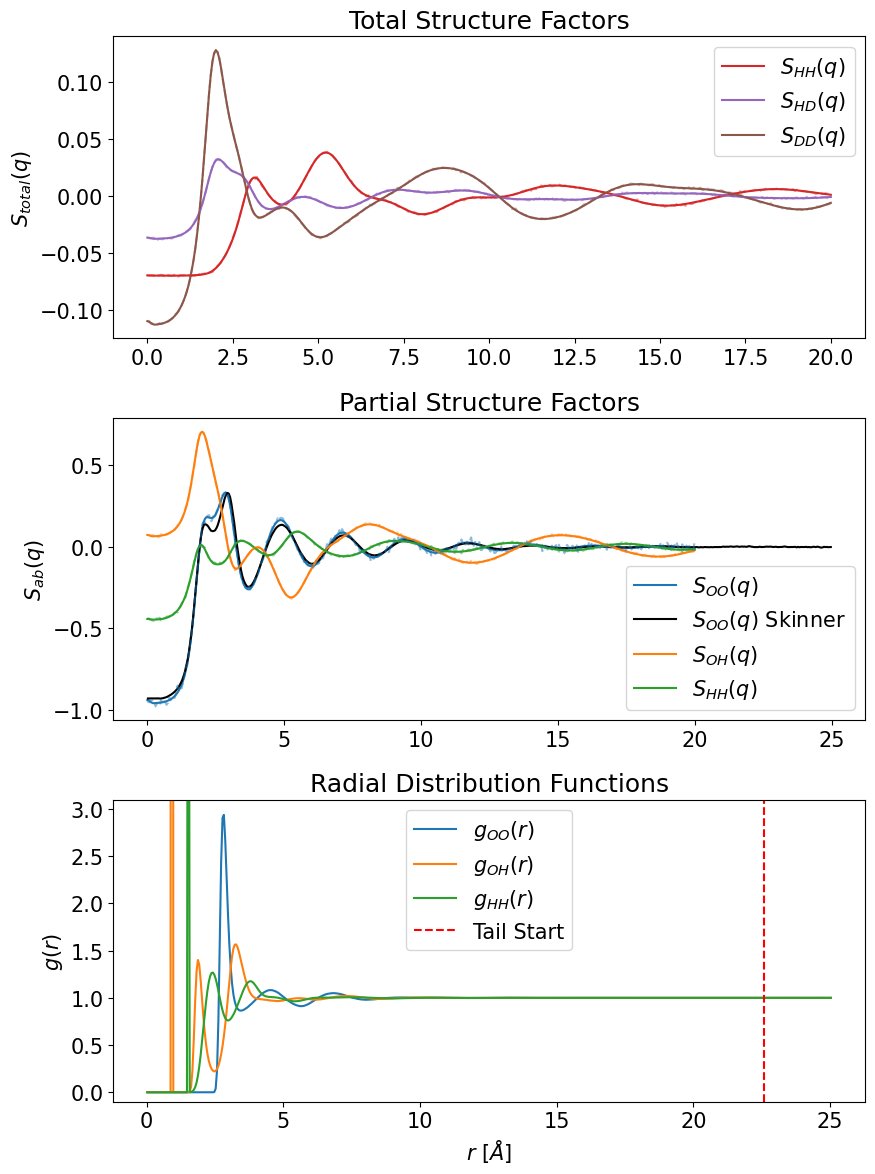

In [2]:
density = 0.0334271795942

import pandas as pd

# Load the data
file_path = 'water_sim_data_matej/Ambient_water_xray_data.txt'
df = pd.read_csv(file_path, sep='\t', skiprows=12, names=[
    'Q', 'I_X(Q)', 'S_OO(Q)', 'r', 'g_OO(r)', 'error'
])

# Convert to PyTorch tensors
Q = torch.tensor(df['Q'].values, dtype=torch.float32)[1:1001:2]
I_X = torch.tensor(df['I_X(Q)'].values, dtype=torch.float32)[1:1001:2]
S_OO_skinner = torch.tensor(df['S_OO(Q)'].values, dtype=torch.float32)[1:1001:2] - 1
r_skinner = torch.tensor(df['r'].values, dtype=torch.float32)[1:]
g_OO_skinner = torch.tensor(df['g_OO(r)'].values, dtype=torch.float32)[1:]
error_skinner = torch.tensor(df['error'].values, dtype=torch.float32)[1:]

# Scattering lengths for water https://www.ncnr.nist.gov/resources/n-lengths/
σOO = 0.0374
σOH = - 0.0964
σHH = 0.0622

σOHD = 0.0378
σHD = 0.0096

σOD = 0.1721 
σDD = 0.1978

M = torch.tensor([[σOO, σOH , σHH],
                  [σOO, σOHD, σHD],
                  [σOO, σOD , σDD]])

M_inv = torch.linalg.inv(M)

# Load in tip4pf data
HH_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_HH.dat")
OH_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_OH.dat")
OO_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_OO.dat")

r_OH,gr_OH = OH_dat.T[0],OH_dat.T[1]
r_OO,gr_OO = OO_dat.T[0],OO_dat.T[1]
r_HH,gr_HH = HH_dat.T[0],HH_dat.T[1]

r_OH = torch.tensor(r_OH)
gr_OH = torch.tensor(gr_OH)
r_HH = torch.tensor(r_HH)
gr_HH = torch.tensor(gr_HH)
r_OO = torch.tensor(r_OO)
gr_OO = torch.tensor(gr_OO)


average_tail_count = 50
print(f'Dividing by the average of values greater than r={r_OH[-average_tail_count]}')
gr_OH =  gr_OH / torch.mean(gr_OH[-average_tail_count:])
gr_OO =  gr_OO / torch.mean(gr_OO[-average_tail_count:])
gr_HH =  gr_HH / torch.mean(gr_HH[-average_tail_count:])


# Store as matrix for easy dot product application to obtain total G(r)
structure_partial = torch.zeros((3,len(gr_OO)))
structure_partial[0] = gr_OO - 1
structure_partial[1] = gr_OH - 1
structure_partial[2] = gr_HH - 1
structure_total = (M @ structure_partial)


# Establish a q space grid and compute total S(q) structure factors
q = torch.linspace(0.001, 20, 400)
sq_HH = gptransform.rdf2sq(r_OO, structure_total[0], q, density)
sq_HD = gptransform.rdf2sq(r_OO, structure_total[1], q, density)
sq_DD = gptransform.rdf2sq(r_OO, structure_total[2], q, density)

# Get noisless partial S(q)
partial_sq_OO = gptransform.rdf2sq(r_OO, gr_OO-1, q, density)
partial_sq_OH = gptransform.rdf2sq(r_OH, gr_OH-1, q, density)
partial_sq_HH = gptransform.rdf2sq(r_HH, gr_HH-1, q, density)

# Sample some random noise to simulate experimental error
noise_HH = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)
noise_HD = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)
noise_DD = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)

# Convert all these things to column vectors for consistency
r = r_OO

r_grid = torch.linspace(0.01, 25  , 1000).reshape(-1,1)
q_values = q.reshape(-1,1)
sq_HH = sq_HH.reshape(-1,1)
sq_HD = sq_HD.reshape(-1,1)
sq_DD = sq_DD.reshape(-1,1)

partial_sq_OO = partial_sq_OO.reshape(-1,1)
partial_sq_OH = partial_sq_OH.reshape(-1,1)
partial_sq_HH = partial_sq_HH.reshape(-1,1)

noise_HH = noise_HH.reshape(-1,1)
noise_HD = noise_HD.reshape(-1,1)
noise_DD = noise_DD.reshape(-1,1)

# We observe the total structure in experimental data, therefore the noise should be added here.
# Constant noise on the total as a function of deuteration doesnt imply constant over partials
# This is why some partials will be harder to learn, we reflect that here in the toy problem.
sq_noisey_HH = (sq_HH+noise_HH)
sq_noisey_HD = (sq_HD+noise_HD)
sq_noisey_DD = (sq_DD+noise_DD)

# Save total noisey and compute partials via matrix inverse
structure_total_q_noisey = torch.zeros((3,len(q)))
structure_total_q_noisey[0] = sq_noisey_HH.T[0]
structure_total_q_noisey[1] = sq_noisey_HD.T[0]
structure_total_q_noisey[2] = sq_noisey_DD.T[0]
structure_partial_q_noisey = M_inv @ structure_total_q_noisey

# Sometimes I will want to refer to them without the matrix
partial_sq_noisey_OO = structure_partial_q_noisey[0].reshape(-1,1)
partial_sq_noisey_OH = structure_partial_q_noisey[1].reshape(-1,1)
partial_sq_noisey_HH = structure_partial_q_noisey[2].reshape(-1,1)
    
# This allows you to mix up the data so its not ordered by q
perm = torch.randperm(len(structure_total_q_noisey[0]))

# Put into Pytorch Dataloader
# Change the reshape command to get different batch sizes, not needed here as there is not enough observations
# so we can do full gradient descent on the LMLH. 
dataset_OO = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[0][perm].reshape(1,400,1))
dataset_OH = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[1][perm].reshape(1,400,1))
dataset_HH = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[2][perm].reshape(1,400,1))
fig, axs = plt.subplots(3, 1, figsize=(9, 12), sharex=False)

# Plot all the functions for visualization
color_OO = 'tab:blue'
color_OH = 'tab:orange'
color_HH = 'tab:green'
color_HH_tot = 'tab:red'
color_HD_tot = 'tab:purple'
color_DD_tot = 'tab:brown'

axs[0].plot(q_values, sq_HH, label="$S_{HH}(q)$", color=color_HH_tot)
axs[0].plot(q_values, sq_HD, label="$S_{HD}(q)$", color=color_HD_tot)
axs[0].plot(q_values, sq_DD, label="$S_{DD}(q)$", color=color_DD_tot)
axs[0].plot(q_values, sq_noisey_HH, linestyle='dashed', alpha=0.5, color=color_HH_tot)
axs[0].plot(q_values, sq_noisey_HD, linestyle='dashed', alpha=0.5, color=color_HD_tot)
axs[0].plot(q_values, sq_noisey_DD, linestyle='dashed', alpha=0.5, color=color_DD_tot)
axs[0].set_ylabel("$S_{total}(q)$")
axs[0].set_title("Total Structure Factors")
axs[0].legend()

axs[1].plot(q_values, partial_sq_OO, label="$S_{OO}(q)$", color=color_OO)
axs[1].plot(Q, S_OO_skinner, label="$S_{OO}(q)$ Skinner", color='k')
axs[1].plot(q_values, partial_sq_OH, label="$S_{OH}(q)$", color=color_OH)
axs[1].plot(q_values, partial_sq_HH, label="$S_{HH}(q)$", color=color_HH)
axs[1].plot(q_values, partial_sq_noisey_OO, linestyle='dashed', alpha=0.5, color=color_OO)
axs[1].plot(q_values, partial_sq_noisey_OH, linestyle='dashed', alpha=0.5, color=color_OH)
axs[1].plot(q_values, partial_sq_noisey_HH, linestyle='dashed', alpha=0.5, color=color_HH)
axs[1].set_ylabel("$S_{ab}(q)$")
axs[1].set_title("Partial Structure Factors")
axs[1].legend()

axs[2].plot(r_OO, gr_OO, label="$g_{OO}(r)$", color=color_OO)
axs[2].plot(r_OH, gr_OH, label="$g_{OH}(r)$", color=color_OH)
axs[2].plot(r_HH, gr_HH, label="$g_{HH}(r)$", color=color_HH)
axs[2].axvline(r_OH[-average_tail_count], linestyle='dashed', color='r', label='Tail Start')
axs[2].set_ylim(-0.1, 3.1)
axs[2].set_xlabel("$r\ [\AA]$")
axs[2].set_ylabel("$g(r)$")
axs[2].set_title("Radial Distribution Functions")
axs[2].legend()

plt.tight_layout()
plt.show()

# Just save these for later
q_infer = q_values
r_infer = r_grid
temp = 298.15

# Run the optimization

Average loss: -329.464740  [    0/  750]
l:       1.224850 
max:     3.020227 
slope:   5.637755 
loc:     2.934557 
decay:   0.538227 
sigma_n: 0.146763 
r_0:     2.786941 
s:       24.959936 
Minutes Taken Since Last Report: 0.107174 



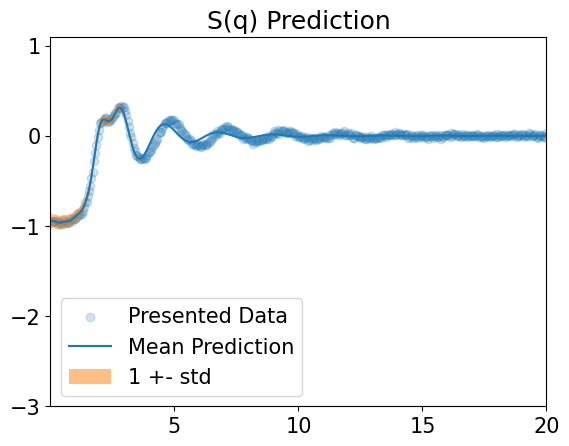

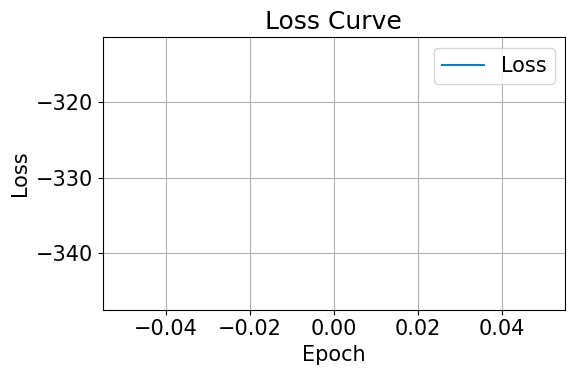

Average loss: -400.752922  [   25/  750]
l:       1.109128 
max:     2.739000 
slope:   6.321071 
loc:     2.794279 
decay:   0.646203 
sigma_n: 0.122329 
r_0:     2.629741 
s:       27.408276 
Minutes Taken Since Last Report: 2.163708 



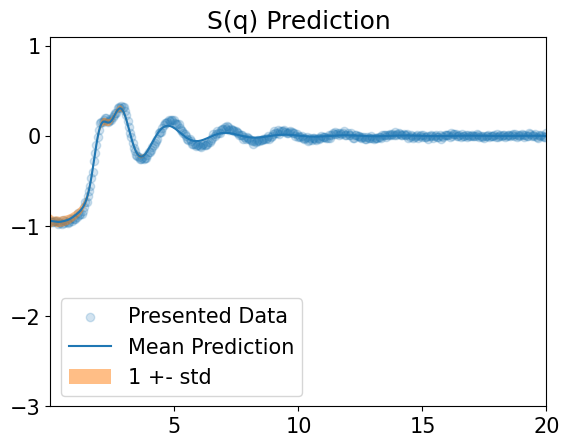

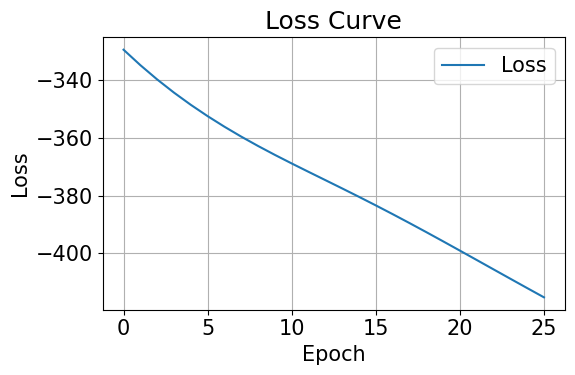

Average loss: -481.270380  [   50/  750]
l:       0.990538 
max:     2.378891 
slope:   7.753306 
loc:     2.781718 
decay:   0.758471 
sigma_n: 0.100415 
r_0:     2.633573 
s:       30.197228 
Minutes Taken Since Last Report: 1.633021 



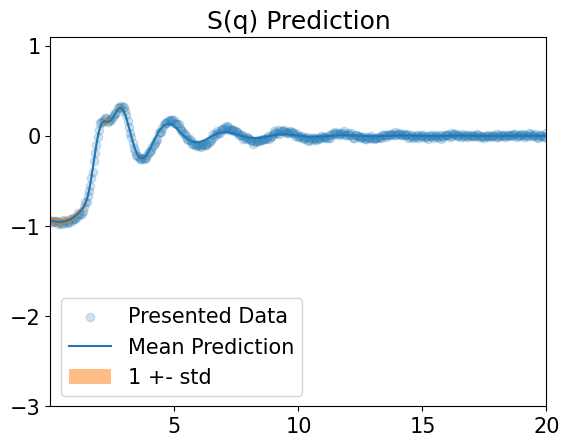

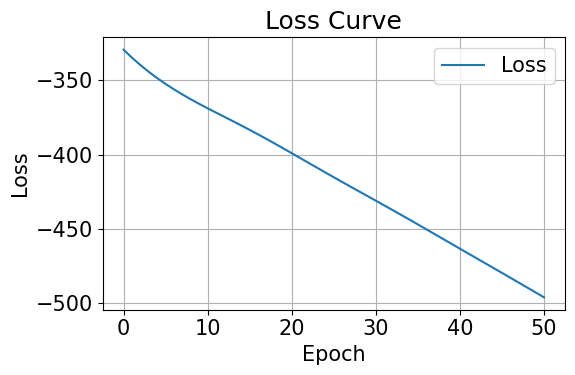

Average loss: -564.771842  [   75/  750]
l:       0.877407 
max:     2.177774 
slope:   9.462309 
loc:     2.755630 
decay:   0.865819 
sigma_n: 0.081258 
r_0:     2.654665 
s:       32.198369 
Minutes Taken Since Last Report: 1.932210 



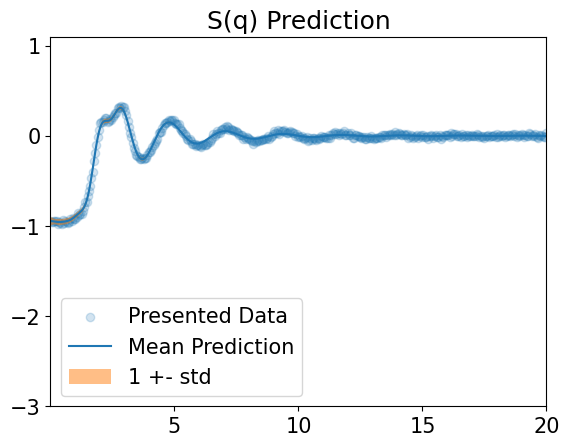

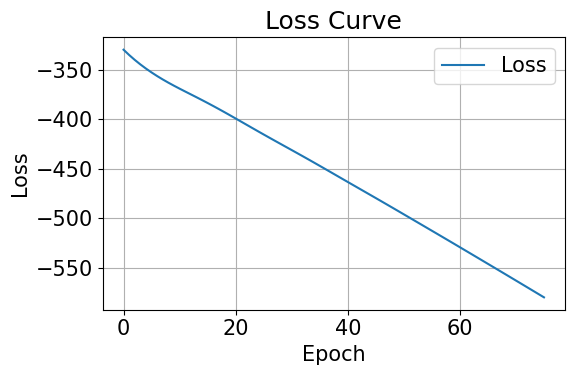

Average loss: -650.494920  [  100/  750]
l:       0.764952 
max:     2.167635 
slope:   11.439915 
loc:     2.742812 
decay:   0.952776 
sigma_n: 0.065009 
r_0:     2.662102 
s:       33.551895 
Minutes Taken Since Last Report: 1.690542 



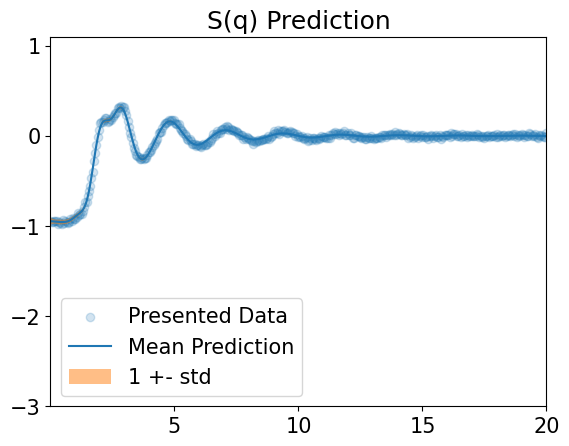

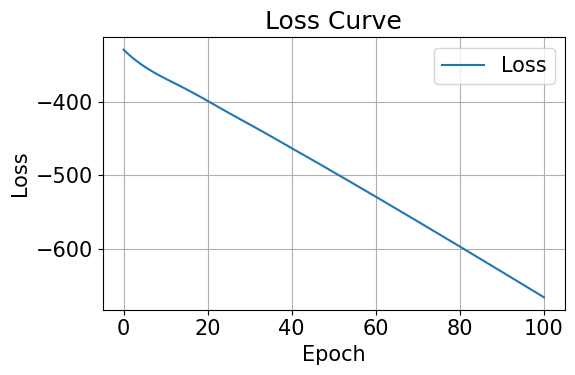

Average loss: -737.529094  [  125/  750]
l:       0.656762 
max:     2.341745 
slope:   13.565364 
loc:     2.738059 
decay:   1.007308 
sigma_n: 0.051571 
r_0:     2.670314 
s:       34.347792 
Minutes Taken Since Last Report: 1.703124 



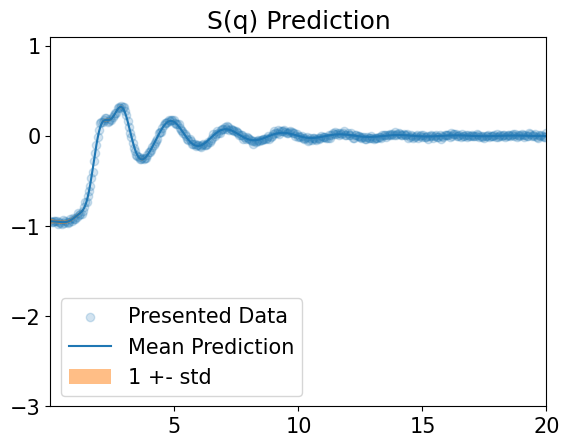

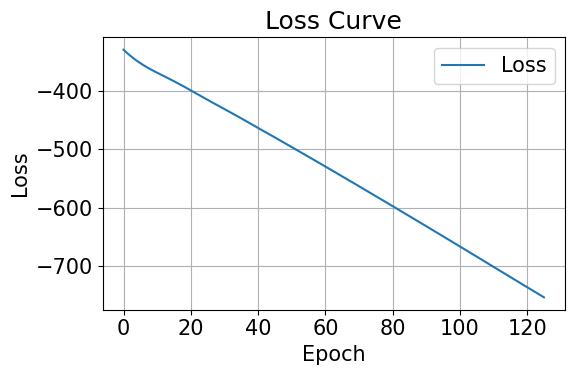

Average loss: -823.127857  [  150/  750]
l:       0.599890 
max:     2.509029 
slope:   15.674341 
loc:     2.732776 
decay:   1.039255 
sigma_n: 0.040740 
r_0:     2.674729 
s:       34.652337 
Minutes Taken Since Last Report: 1.769430 



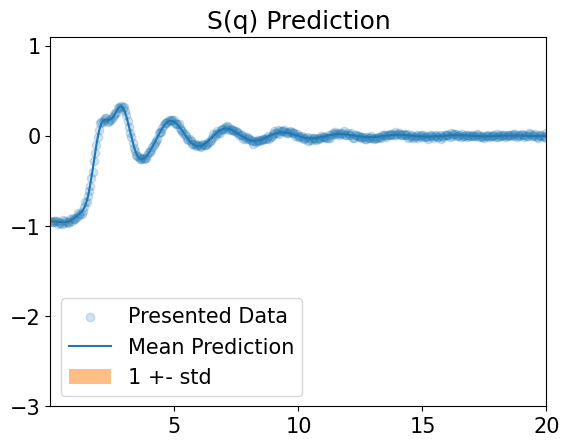

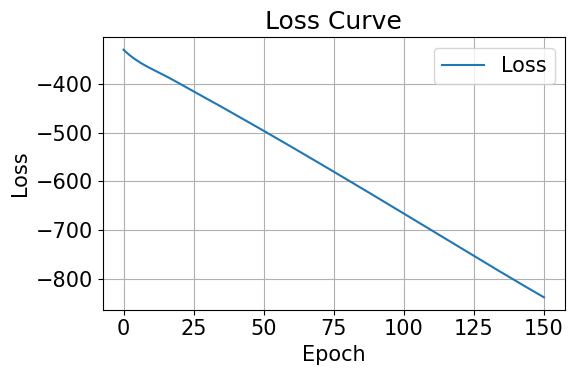

Average loss: -904.369509  [  175/  750]
l:       0.576347 
max:     2.680619 
slope:   17.679180 
loc:     2.727691 
decay:   1.046190 
sigma_n: 0.032235 
r_0:     2.676927 
s:       34.650525 
Minutes Taken Since Last Report: 1.947703 



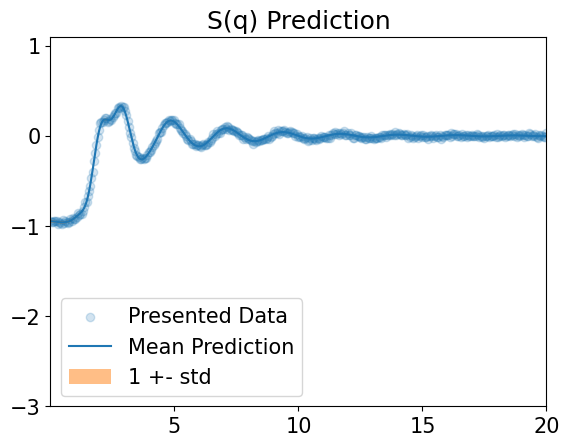

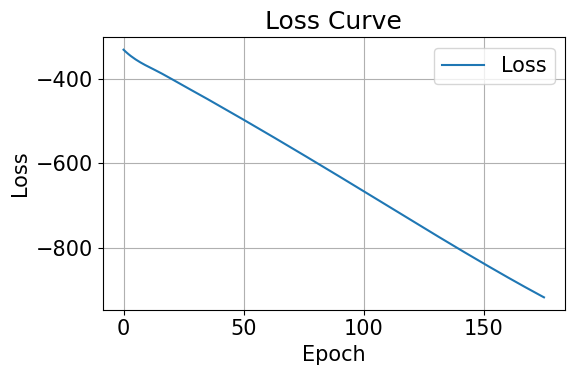

Average loss: -977.370995  [  200/  750]
l:       0.578999 
max:     2.806626 
slope:   19.498285 
loc:     2.722926 
decay:   1.046155 
sigma_n: 0.025730 
r_0:     2.677765 
s:       34.392490 
Minutes Taken Since Last Report: 1.888602 



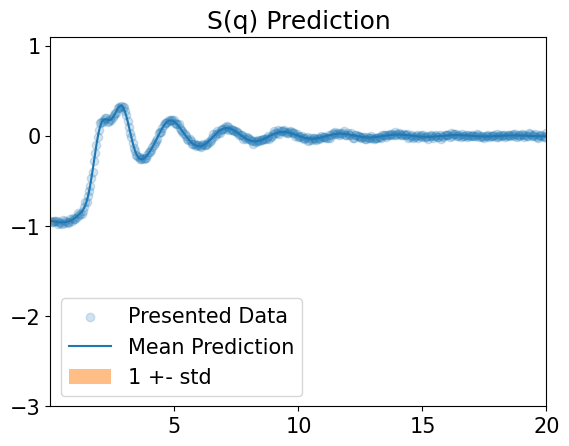

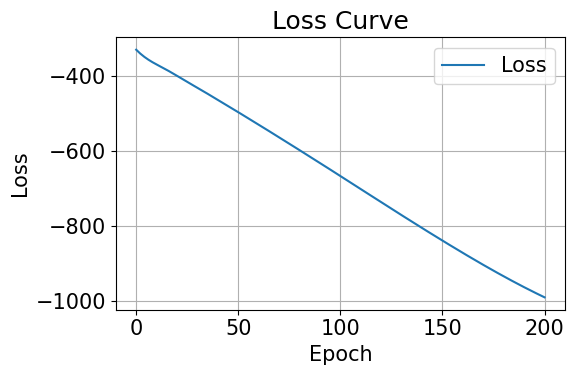

Average loss: -1037.313848  [  225/  750]
l:       0.592957 
max:     2.932654 
slope:   21.066292 
loc:     2.719553 
decay:   1.045614 
sigma_n: 0.020918 
r_0:     2.677449 
s:       33.845517 
Minutes Taken Since Last Report: 1.764113 



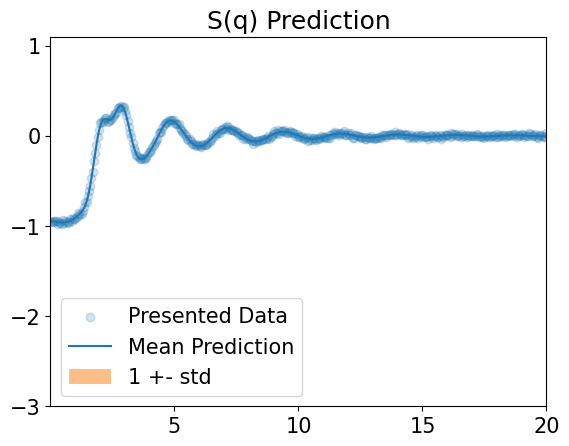

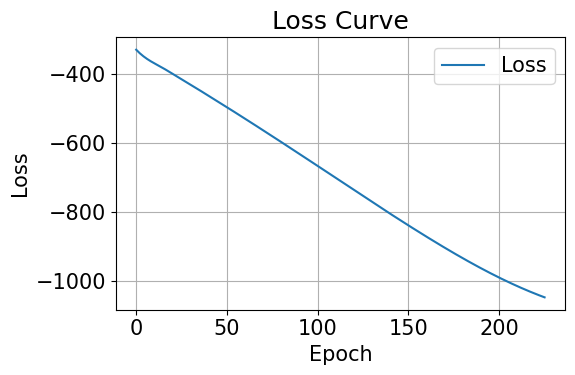

Average loss: -1080.167263  [  250/  750]
l:       0.604627 
max:     3.071934 
slope:   22.288424 
loc:     2.718617 
decay:   1.048696 
sigma_n: 0.017518 
r_0:     2.674394 
s:       32.778264 
Minutes Taken Since Last Report: 1.572192 



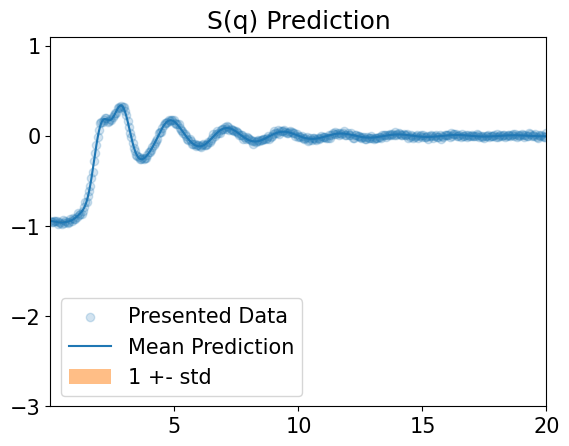

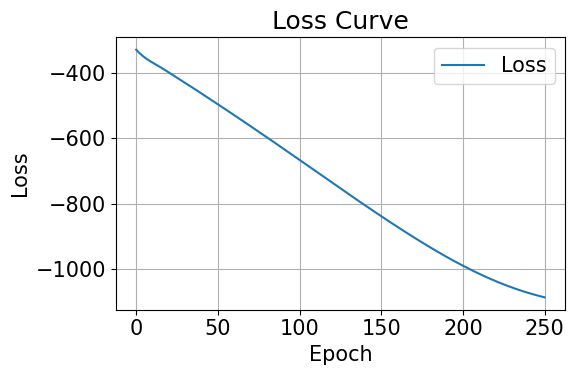

Average loss: -1105.258287  [  275/  750]
l:       0.612317 
max:     3.211017 
slope:   23.136769 
loc:     2.721051 
decay:   1.054208 
sigma_n: 0.015274 
r_0:     2.666408 
s:       31.191607 
Minutes Taken Since Last Report: 1.739296 



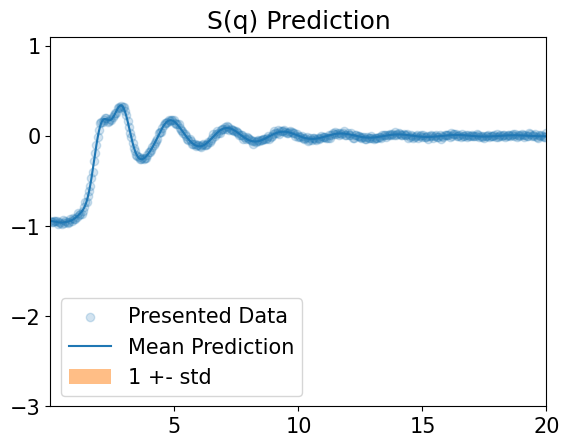

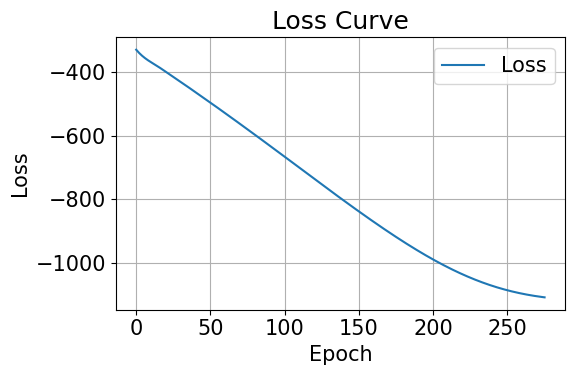

Average loss: -1116.285082  [  300/  750]
l:       0.615562 
max:     3.350213 
slope:   23.732928 
loc:     2.720894 
decay:   1.060455 
sigma_n: 0.013932 
r_0:     2.669725 
s:       29.847709 
Minutes Taken Since Last Report: 1.928937 



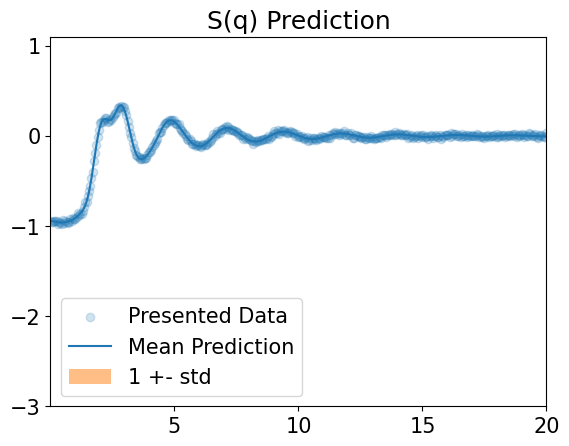

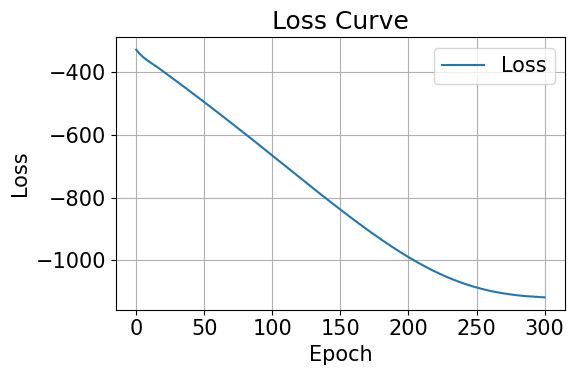

Average loss: -1120.358004  [  325/  750]
l:       0.622316 
max:     3.458909 
slope:   24.173677 
loc:     2.724406 
decay:   1.065569 
sigma_n: 0.013226 
r_0:     2.656975 
s:       29.107025 
Minutes Taken Since Last Report: 1.886268 



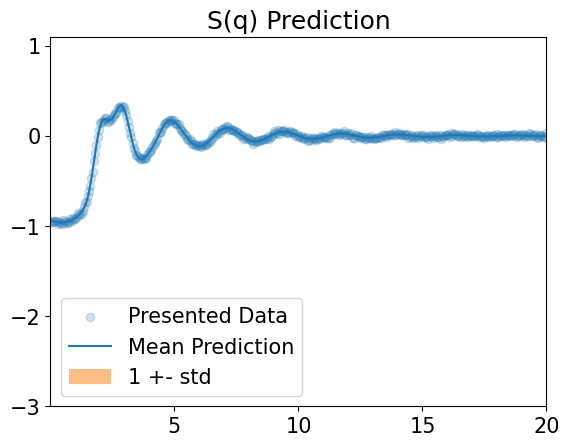

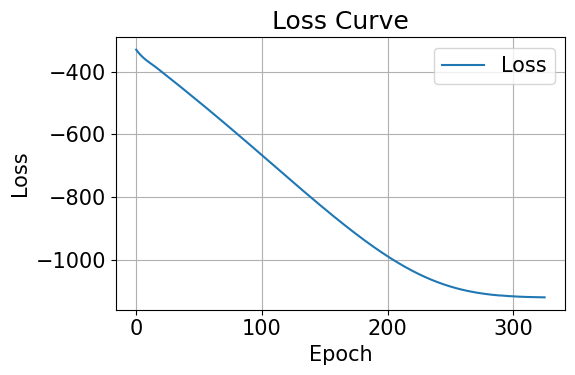

Average loss: -1121.392154  [  350/  750]
l:       0.626357 
max:     3.555003 
slope:   24.636085 
loc:     2.726863 
decay:   1.069660 
sigma_n: 0.012905 
r_0:     2.649532 
s:       29.295515 
Minutes Taken Since Last Report: 1.851964 



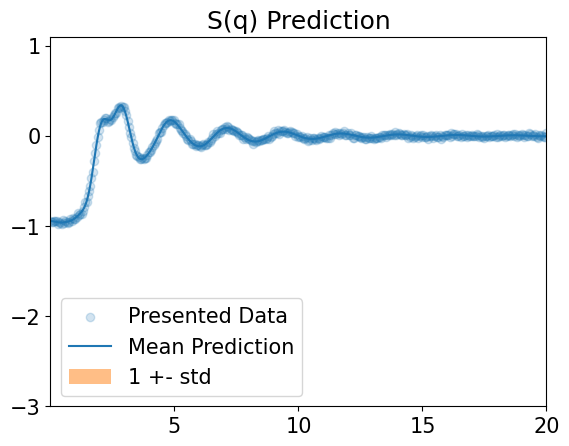

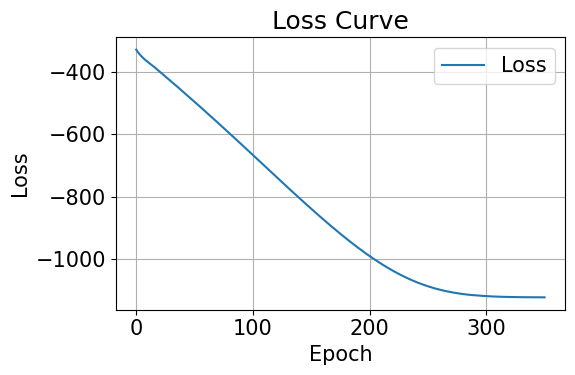

Average loss: -1121.646874  [  375/  750]
l:       0.628987 
max:     3.626355 
slope:   25.060002 
loc:     2.727846 
decay:   1.072845 
sigma_n: 0.012779 
r_0:     2.645698 
s:       29.497650 
Minutes Taken Since Last Report: 1.835249 



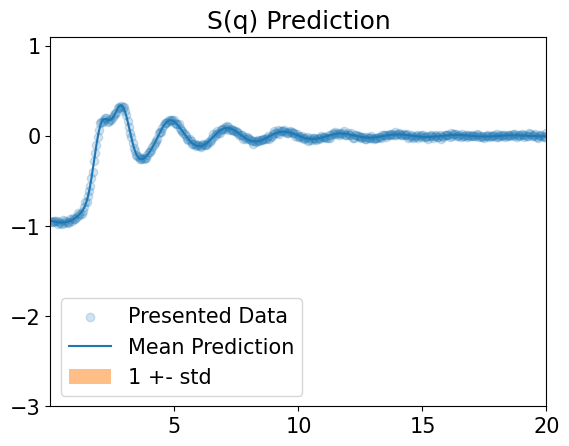

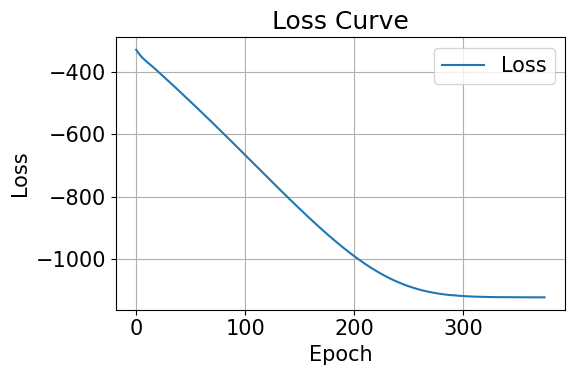

Average loss: -1121.724584  [  400/  750]
l:       0.630886 
max:     3.673737 
slope:   25.439928 
loc:     2.728429 
decay:   1.074857 
sigma_n: 0.012736 
r_0:     2.642421 
s:       29.594739 
Minutes Taken Since Last Report: 1.707071 



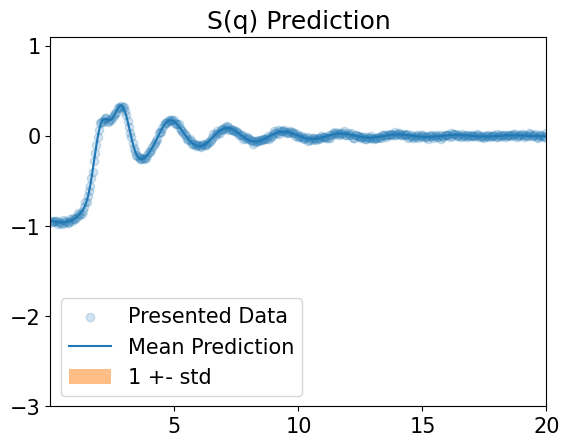

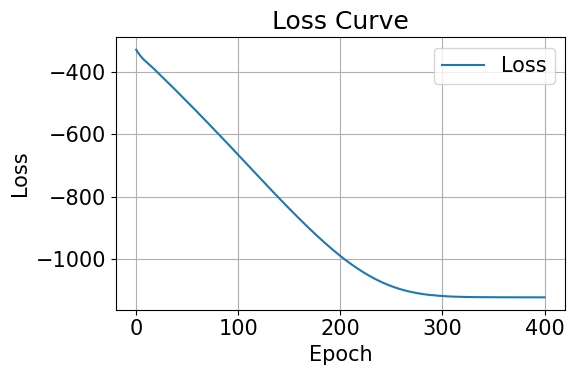

Average loss: -1121.759241  [  425/  750]
l:       0.632061 
max:     3.701800 
slope:   25.783115 
loc:     2.728794 
decay:   1.076045 
sigma_n: 0.012721 
r_0:     2.640026 
s:       29.657856 
Minutes Taken Since Last Report: 1.617501 



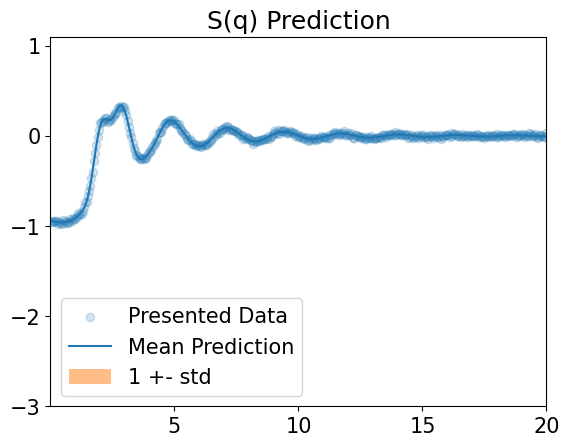

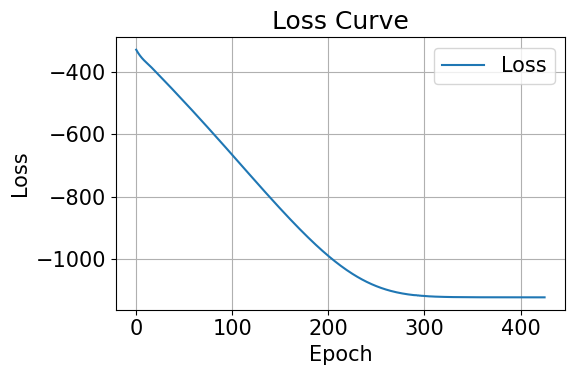

Average loss: -1121.780931  [  450/  750]
l:       0.632747 
max:     3.715897 
slope:   26.094794 
loc:     2.729019 
decay:   1.076610 
sigma_n: 0.012714 
r_0:     2.638052 
s:       29.715977 
Minutes Taken Since Last Report: 1.640788 



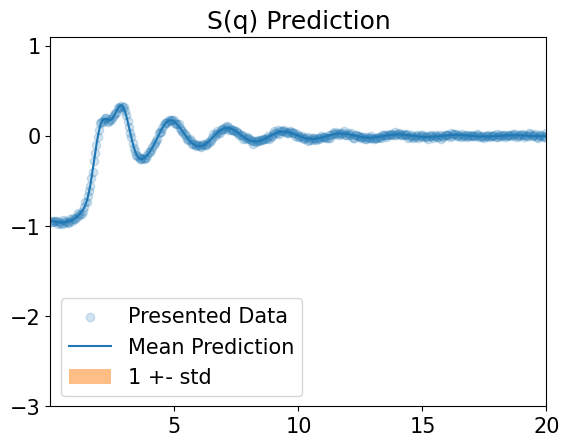

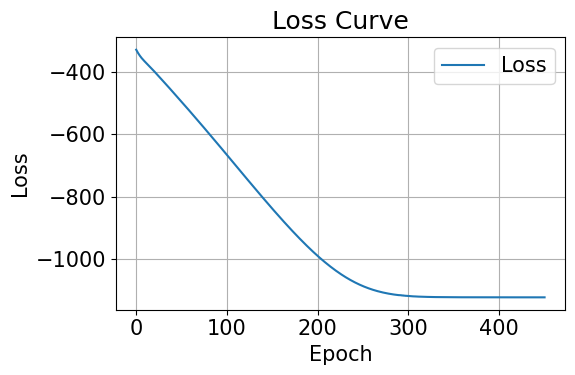

Average loss: -1121.797468  [  475/  750]
l:       0.633092 
max:     3.720587 
slope:   26.379110 
loc:     2.729164 
decay:   1.076767 
sigma_n: 0.012709 
r_0:     2.636382 
s:       29.774450 
Minutes Taken Since Last Report: 1.733789 



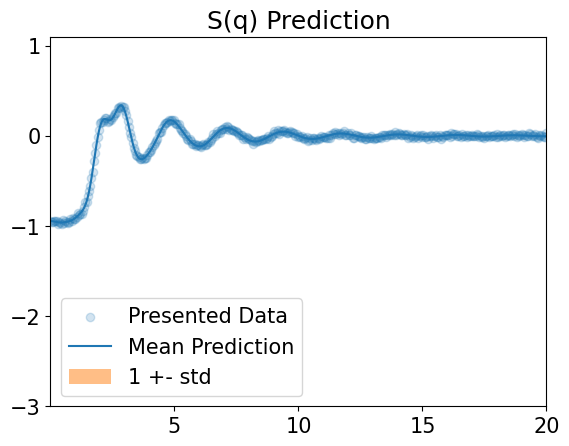

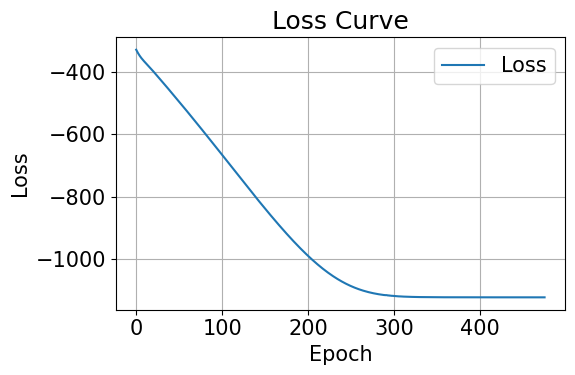

Average loss: -1121.811056  [  500/  750]
l:       0.633221 
max:     3.719330 
slope:   26.639240 
loc:     2.729256 
decay:   1.076666 
sigma_n: 0.012705 
r_0:     2.634948 
s:       29.832336 
Minutes Taken Since Last Report: 1.858481 



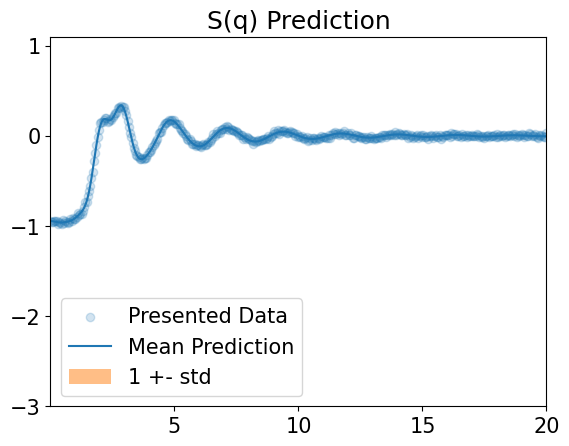

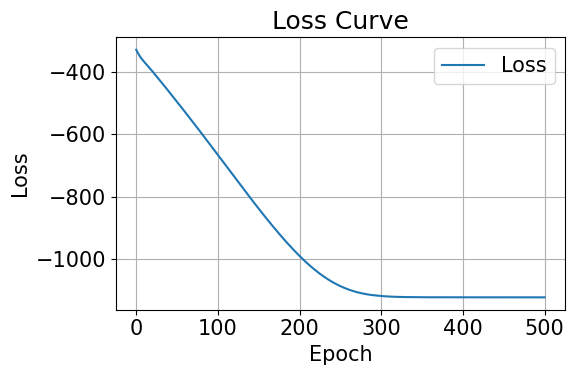

Average loss: -1121.821985  [  525/  750]
l:       0.633210 
max:     3.714523 
slope:   26.878016 
loc:     2.729598 
decay:   1.076413 
sigma_n: 0.012701 
r_0:     2.634317 
s:       29.889989 
Minutes Taken Since Last Report: 1.960798 



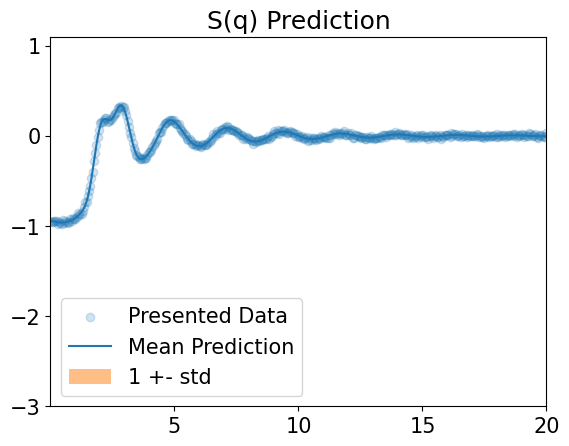

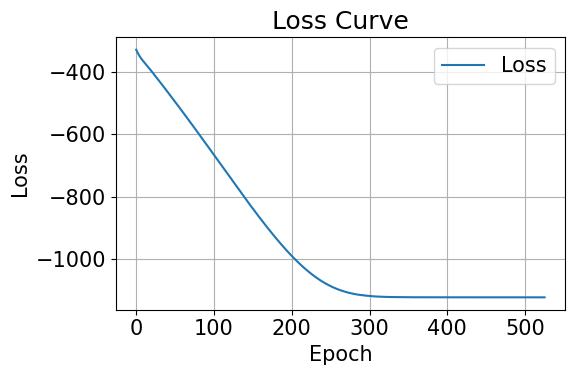

Average loss: -1121.789716  [  550/  750]
l:       0.632682 
max:     3.706005 
slope:   27.060849 
loc:     2.729997 
decay:   1.076561 
sigma_n: 0.012699 
r_0:     2.634371 
s:       29.705912 
Minutes Taken Since Last Report: 2.498296 



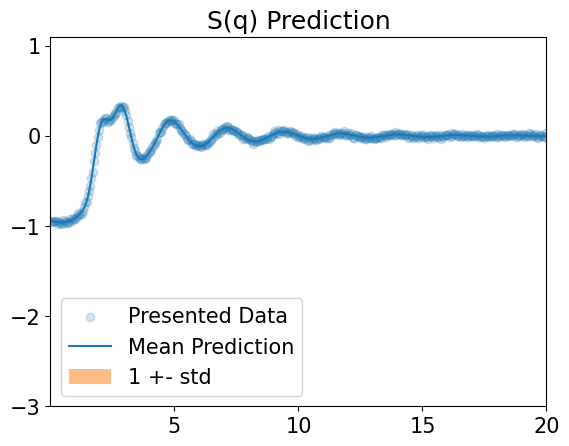

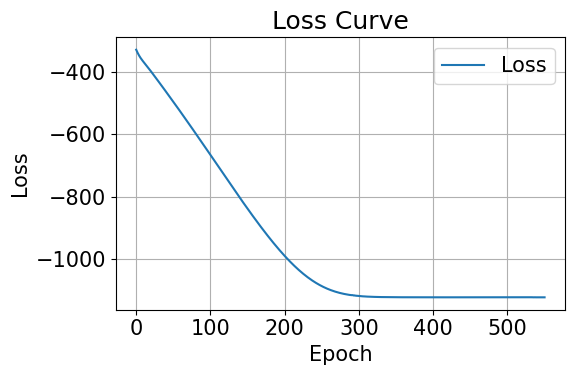

Average loss: -1121.834624  [  575/  750]
l:       0.633105 
max:     3.699158 
slope:   27.245368 
loc:     2.729331 
decay:   1.075574 
sigma_n: 0.012695 
r_0:     2.632126 
s:       29.837070 
Minutes Taken Since Last Report: 2.374477 



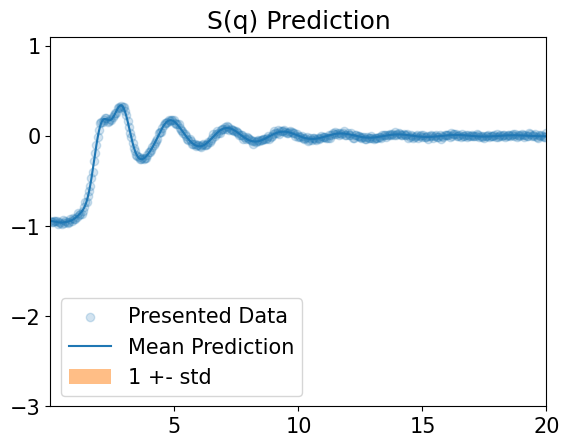

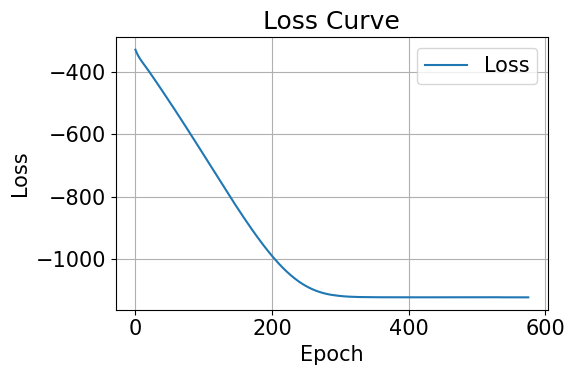

Average loss: -1121.845057  [  600/  750]
l:       0.632798 
max:     3.691772 
slope:   27.428363 
loc:     2.729401 
decay:   1.075331 
sigma_n: 0.012691 
r_0:     2.631250 
s:       29.982054 
Minutes Taken Since Last Report: 2.306122 



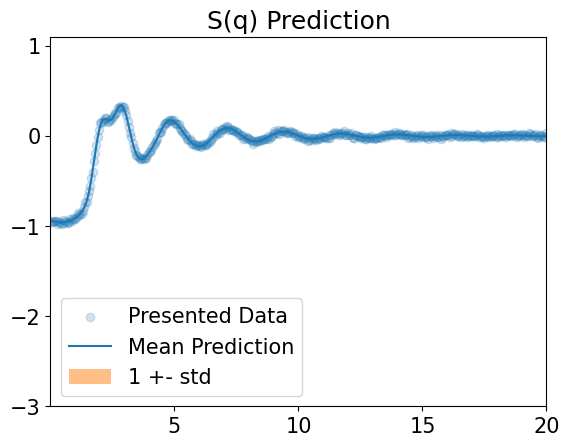

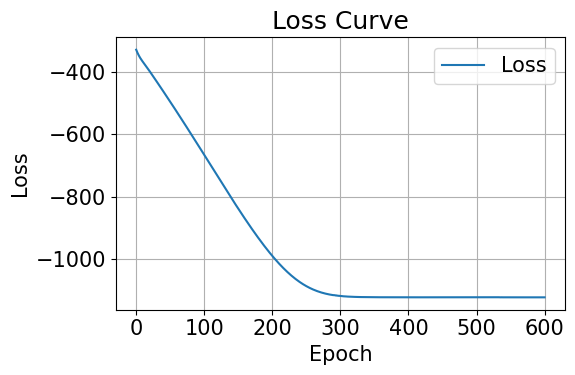

Average loss: -1121.851455  [  625/  750]
l:       0.632698 
max:     3.685069 
slope:   27.598665 
loc:     2.729324 
decay:   1.074975 
sigma_n: 0.012687 
r_0:     2.630328 
s:       30.049536 
Minutes Taken Since Last Report: 2.107203 



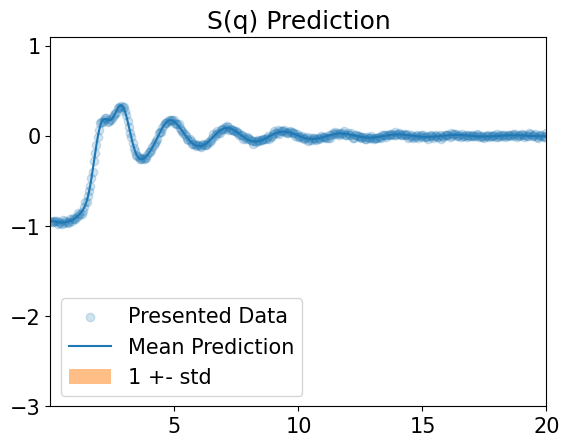

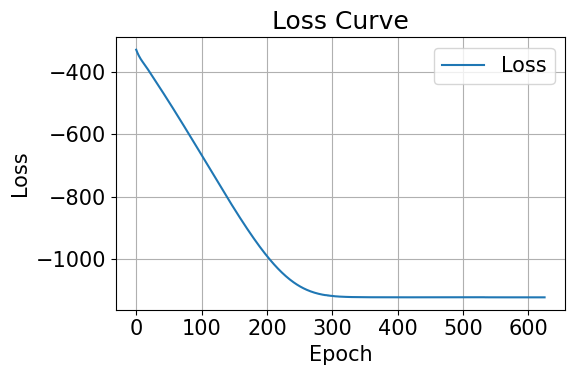

Average loss: -1121.856598  [  650/  750]
l:       0.632564 
max:     3.678465 
slope:   27.755383 
loc:     2.729337 
decay:   1.074657 
sigma_n: 0.012685 
r_0:     2.629670 
s:       30.092644 
Minutes Taken Since Last Report: 2.116629 



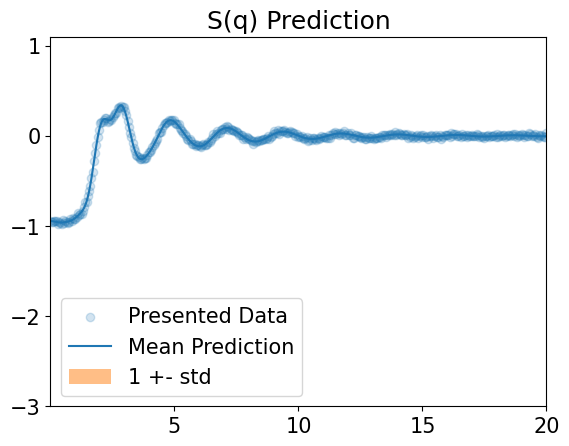

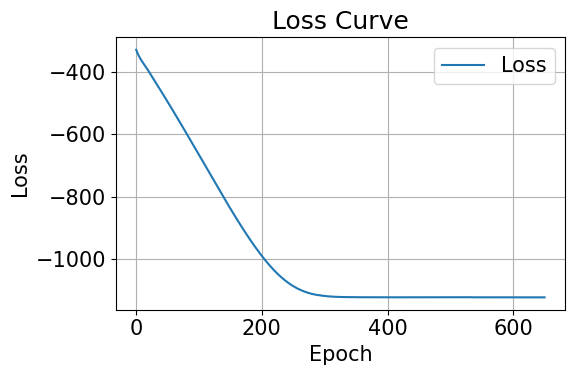

Average loss: -1121.860937  [  675/  750]
l:       0.632434 
max:     3.672054 
slope:   27.898959 
loc:     2.729344 
decay:   1.074345 
sigma_n: 0.012682 
r_0:     2.629069 
s:       30.133465 
Minutes Taken Since Last Report: 2.065299 



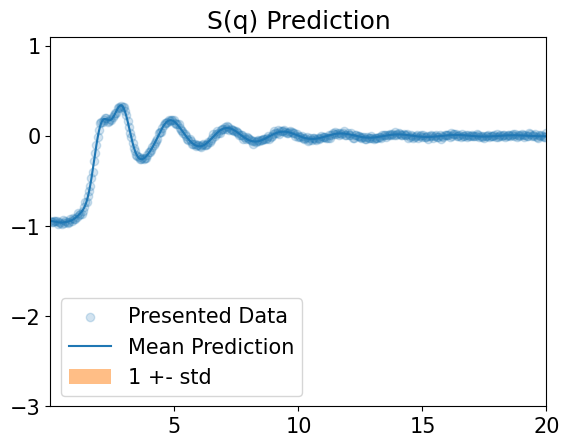

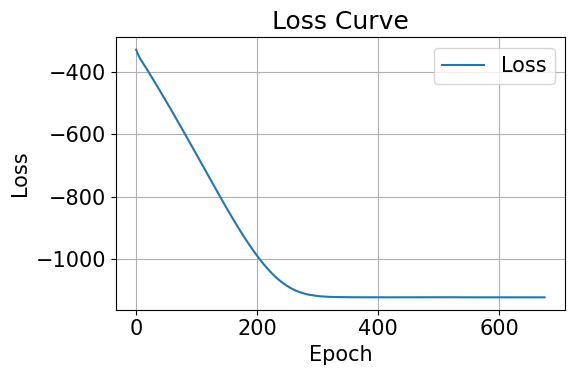

Average loss: -1121.864652  [  700/  750]
l:       0.632308 
max:     3.665983 
slope:   28.030340 
loc:     2.729338 
decay:   1.074050 
sigma_n: 0.012679 
r_0:     2.628519 
s:       30.172991 
Minutes Taken Since Last Report: 2.191173 



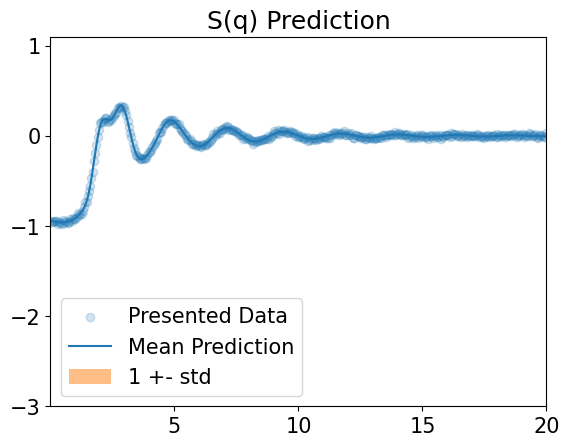

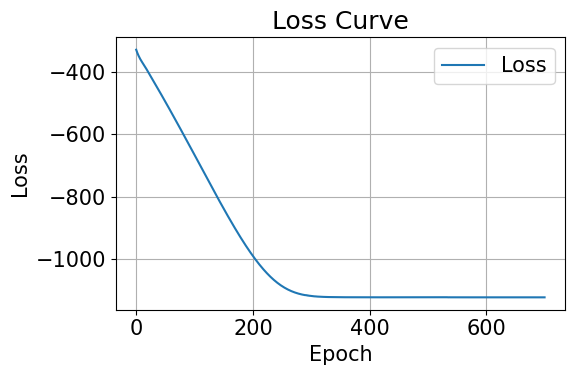

Average loss: -1121.867845  [  725/  750]
l:       0.632187 
max:     3.660341 
slope:   28.150447 
loc:     2.729331 
decay:   1.073776 
sigma_n: 0.012677 
r_0:     2.628026 
s:       30.209875 
Minutes Taken Since Last Report: 2.465568 



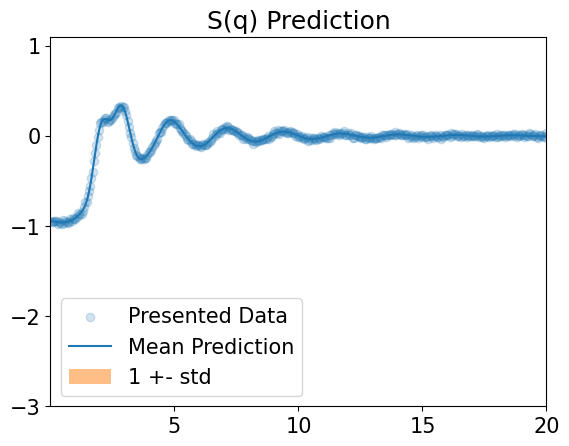

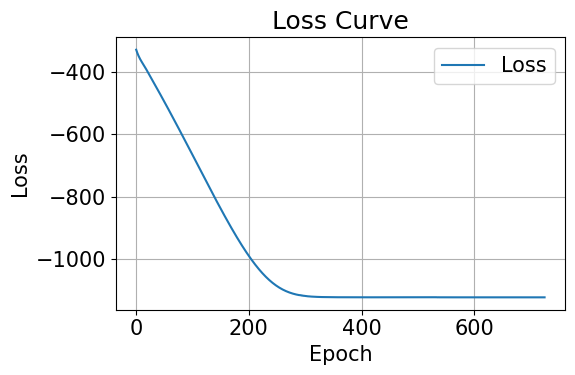

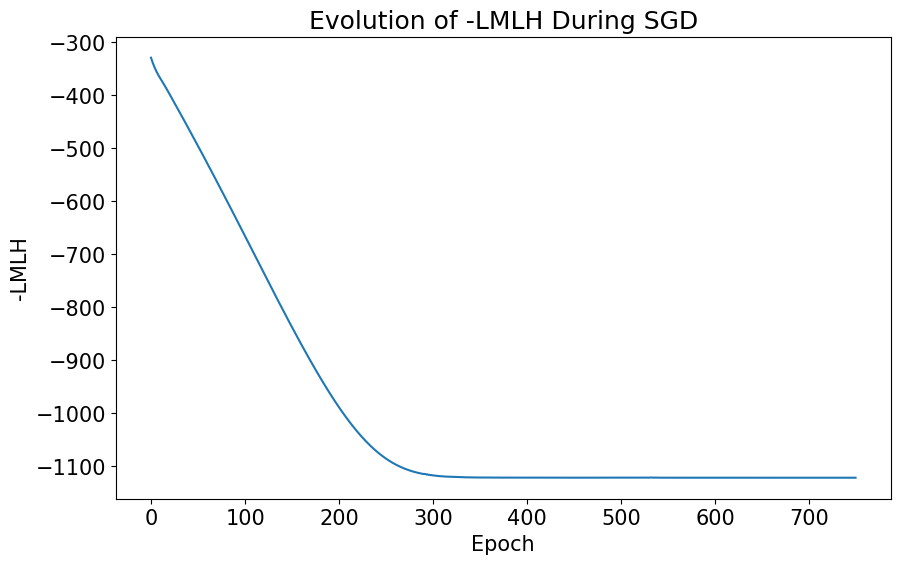

In [3]:
psq_name = 'OO'

init_param_bounds = torch.zeros((8,2))

### Width Function Params ###

# Ell
init_param_bounds[0,1] = 2.5
init_param_bounds[0,0] = 0.1

# Max
init_param_bounds[1,1] = 10
init_param_bounds[1,0] = 0.2

# Slope
init_param_bounds[2,1] = 50
init_param_bounds[2,0] = 1

# Loc
init_param_bounds[3,1] = 6
init_param_bounds[3,0] = 0.5

# Decay
init_param_bounds[4,1] = 3
init_param_bounds[4,0] = 0.05

### Experimental Noise ###

# Sigma_n
init_param_bounds[5,1] = 0.5
init_param_bounds[5,0] = 0.0001

### Non-Bonded Peaks in Mean ###

# r_0
init_param_bounds[6,1] = 20
init_param_bounds[6,0] = 0.01

# s
init_param_bounds[7,1] = 50
init_param_bounds[7,0] = 0.001

# Create initial parameters, just a guess I found that converged after a few tries
init_params = torch.tensor([1.230821, 3, 5.678962, 2.948104, 0.53410, 0.147792, 2.810502, 25.084942 ])

model_path = 'models/'+str(temp)+'_'+psq_name+'_GP'
loss_path = 'models/'+str(temp)+'_'+psq_name+'_losses.pt'


# Create GP Object
gp = gptransform.GP(init_params, init_param_bounds, 0, density, temp)

# Perform hyper parameter optimization
optimizer = torch.optim.AdamW(gp.parameters(), lr=1e-2)
losses = gptransform.train_loop(dataset_OO, gp, optimizer, 750, r_grid, q_values,  partial_sq_noisey_OO, q_infer, r_infer, -3,1.1, -0.1,3.1)

# Save GP
torch.save(gp, model_path)
torch.save(torch.tensor(losses), loss_path)

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(losses, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('-LMLH')
plt.title('Evolution of -LMLH During SGD')
plt.savefig('figs/'+str(temp)+'_'+psq_name+'_LMLH.png')
plt.show()

# Resulting Hyper Parameters

In [4]:
names = ["l", "max", "slope", "loc", "decay", "sigma_n", "r_0", "s"]

print(f"{'Name':<10} {'Init Value':<12} {'Lower Bound':<15} {'Upper Bound':<15} {'Final Value':<15} {'Δ':<12} {'% Change':<10}")
print("-" * 100)

for name, init, lo, hi, final in zip(
    names,
    init_params.tolist(),
    init_param_bounds.T[0].tolist(),
    init_param_bounds.T[1].tolist(),
    gp.theta.tolist()
):
    delta = final - init
    denom = hi - lo
    percent = 100 * delta / denom 
    print(f"{name:<10} {init:<12.6f} {lo:<15.6f} {hi:<15.6f} {final:<15.6f} {delta:<12.6f} {percent:<10.2f}")


Name       Init Value   Lower Bound     Upper Bound     Final Value     Δ            % Change  
----------------------------------------------------------------------------------------------------
l          1.230821     0.100000        2.500000        0.632084        -0.598737    -24.95    
max        3.000000     0.200000        10.000000       3.655550        0.655550     6.69      
slope      5.678962     1.000000        50.000000       28.251700       22.572738    46.07     
loc        2.948104     0.500000        6.000000        2.729322        -0.218782    -3.98     
decay      0.534100     0.050000        3.000000        1.073544        0.539444     18.29     
sigma_n    0.147792     0.000100        0.500000        0.012675        -0.135117    -27.03    
r_0        2.810502     0.010000        20.000000       2.627613        -0.182889    -0.91     
s          25.084942    0.001000        50.000000       30.241305       5.156363     10.31     


# Apply Laplaces Approximation

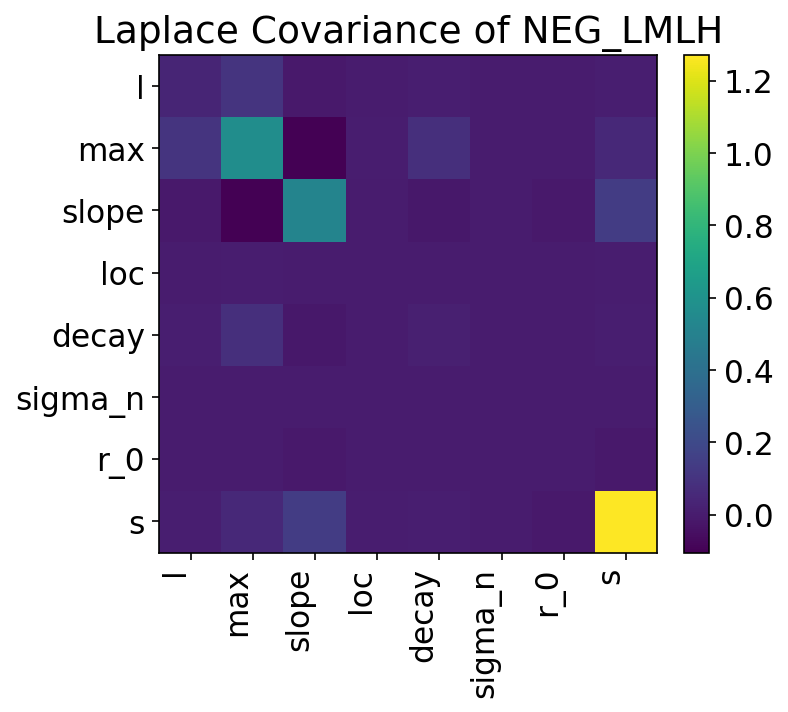

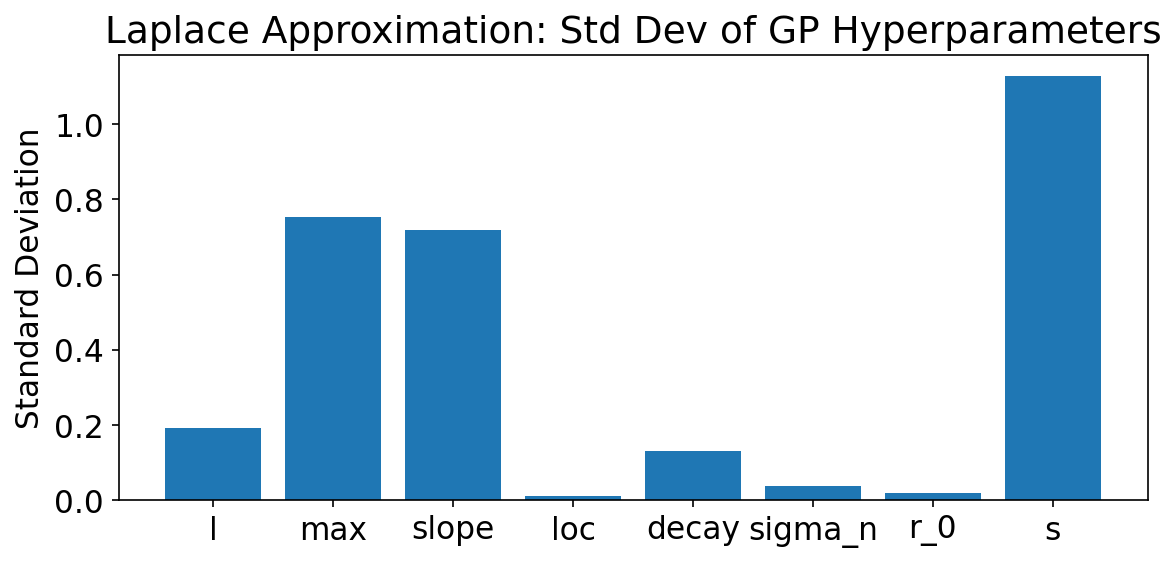

In [5]:
q_train = q_values
sq_train = partial_sq_noisey_OO

loss_at_map = gp.NEG_LMLH_Trapz(r_grid, q_values, sq_train)

grad = torch.autograd.grad(loss_at_map, gp.theta_raw, create_graph=True)[0]  # shape: (P,)
P = grad.numel()
grad_flat = grad.view(-1)

H = torch.zeros(P, P, device=grad.device)
for i in range(P):
    grad2 = torch.autograd.grad(grad_flat[i], gp.theta_raw, retain_graph=True)[0].view(-1)
    H[i] = grad2.detach()

L = torch.linalg.cholesky(gp.nearestPD(H))  
cov_laplace = torch.cholesky_inverse(L)

stds = torch.sqrt(torch.diag(cov_laplace)).cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
im = ax.imshow(cov_laplace, cmap='viridis')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(range(P))
ax.set_yticks(range(P))
ax.set_xticklabels(names, rotation=90, ha='right')
ax.set_yticklabels(names)
ax.set_title("Laplace Covariance of NEG_LMLH")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.bar(names, stds)
ax.set_ylabel("Standard Deviation")
ax.set_title("Laplace Approximation: Std Dev of GP Hyperparameters")
plt.tight_layout()
plt.show()

#  Compute the Posteriors

In [6]:
with torch.no_grad():

    r_grid =  torch.linspace(0.01, 25  , 1000).reshape(-1,1)
    r_infer = torch.linspace(0.01, 12.5, 1000).reshape(-1,1)
    q_infer = torch.linspace(0.01, 12.5, 1000).reshape(-1,1)

    # Calculate Posterior Mean and Cov in momentum space
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    μ_q_prior = gp.mean_q(r_grid,q_infer)
    Σ_q_prior = gp.K_qq(r_grid, r_grid, q_infer, q_infer,adjust=False)

    # Calculate Posterior Mean and Cov in real space
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()
    
    μ_r_prior = gp.mean_r(r_infer)
    Σ_r_prior = gp.K_rr(r_infer, r_infer,adjust=False)

    kernels = [(Σ_q_post, q_infer.T[0], q_infer.T[0]),(Σ_r_post, r_infer.T[0], r_infer.T[0])]   

# Plot the Posteriors

/var/folders/tv/1d811xv917v4wz50x1bqpvcc0000gn/T/ipykernel_31809/3986530217.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


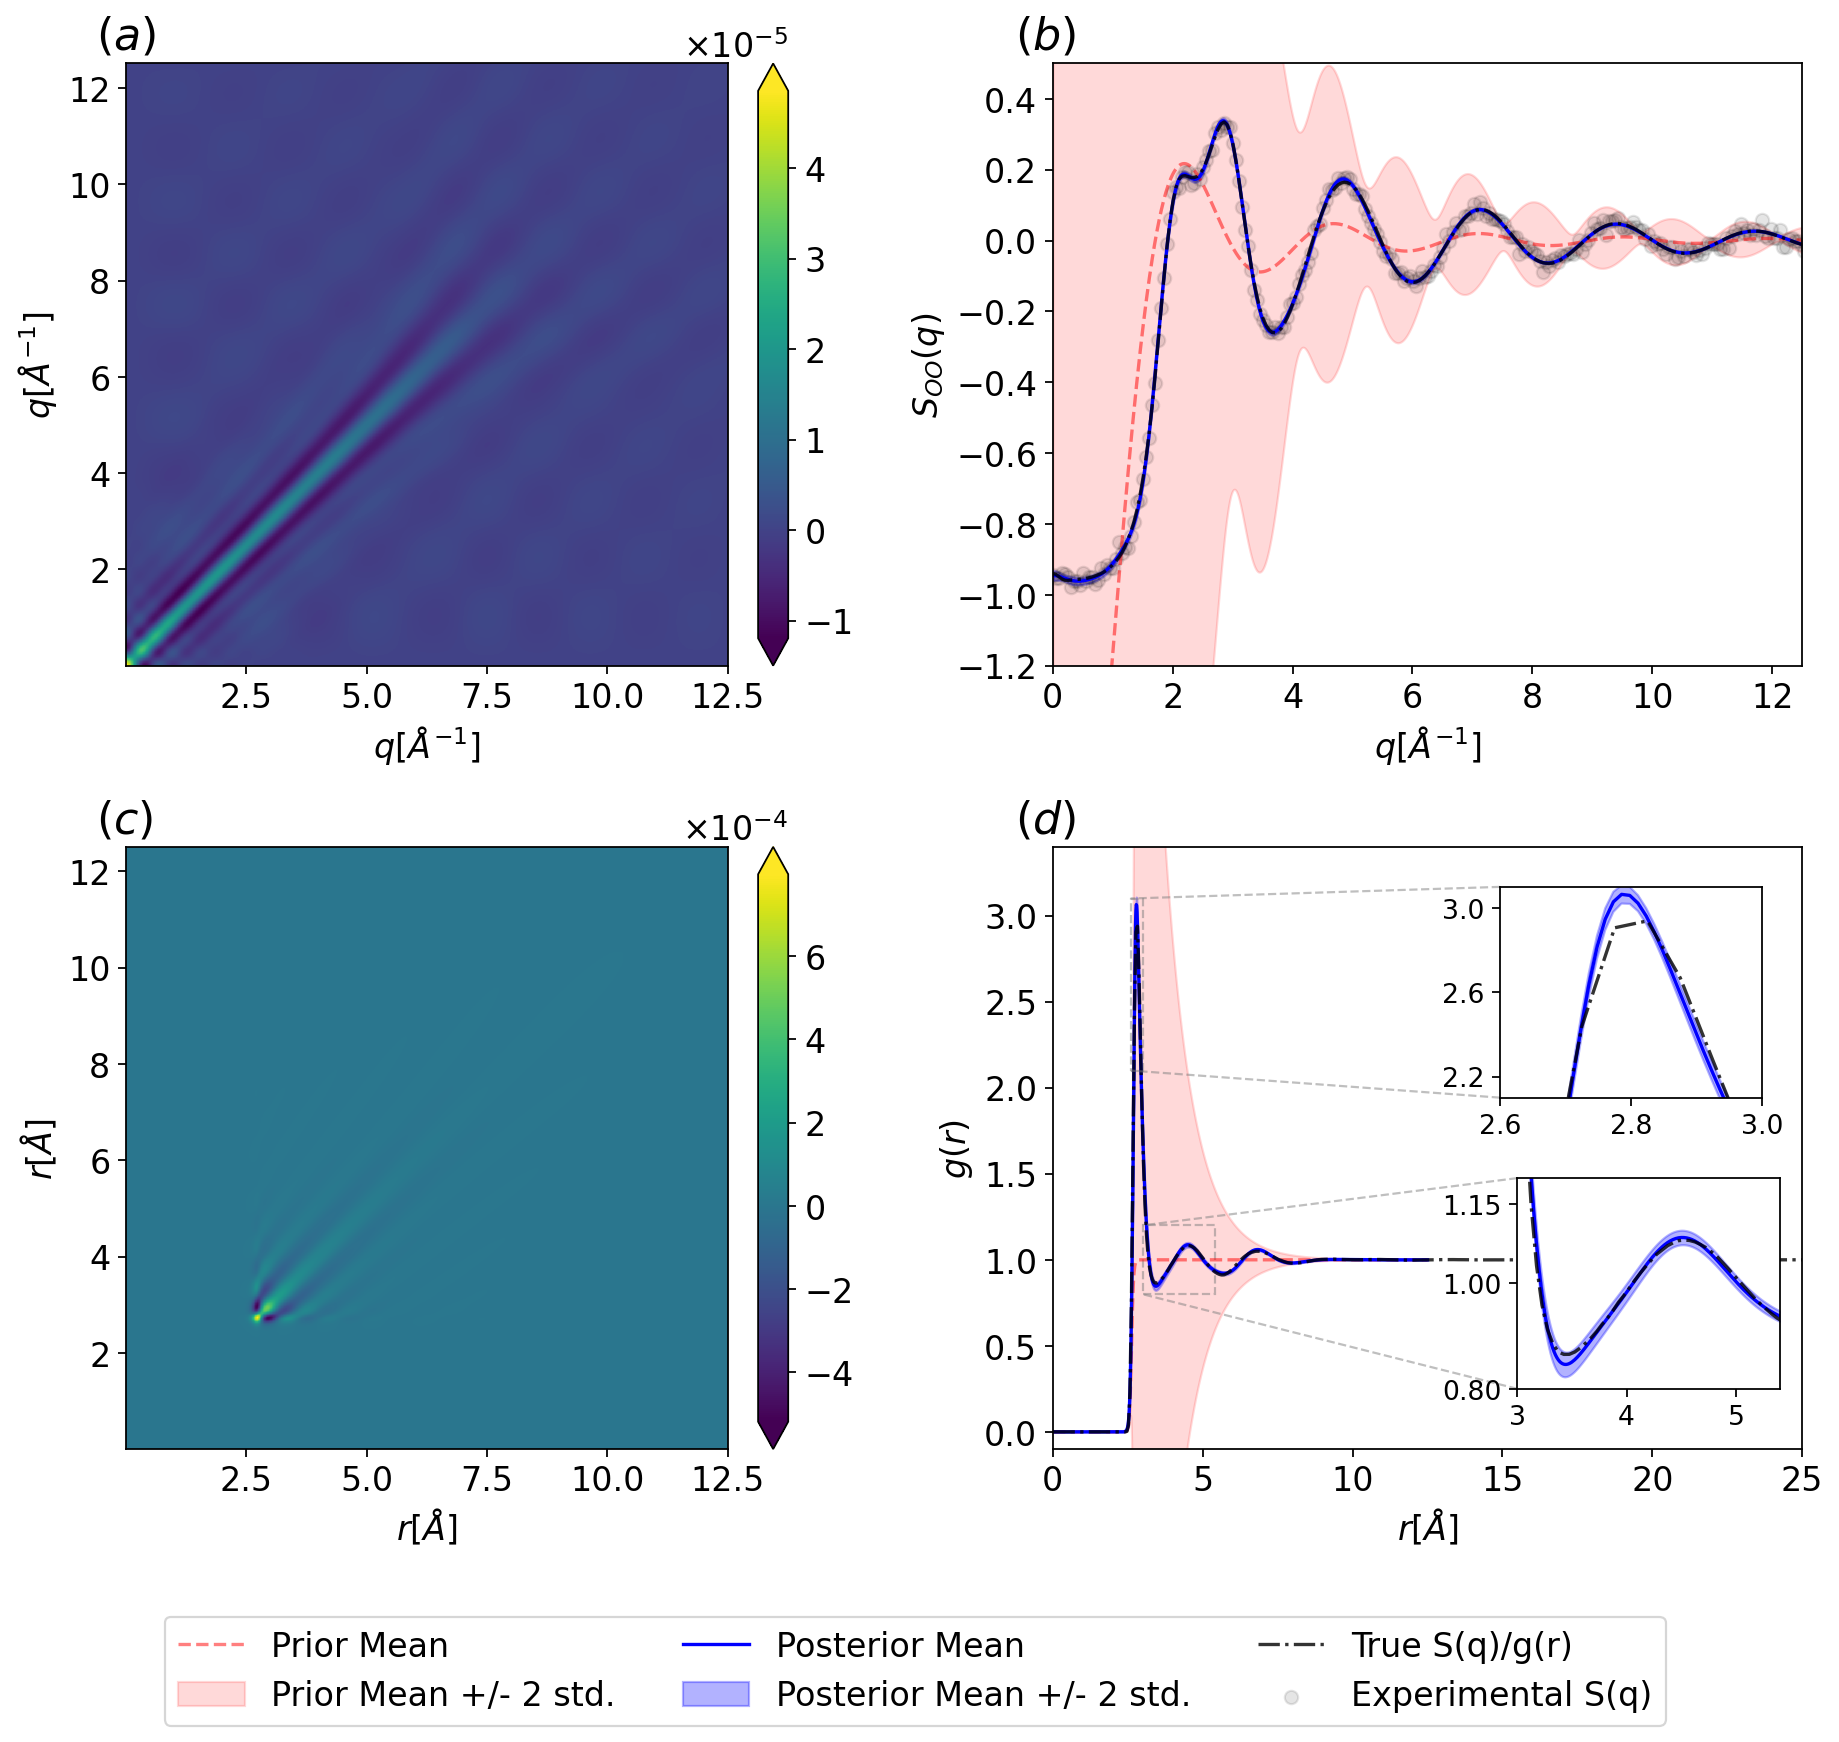

In [7]:
titles = ["$\Sigma_{{Post.}}$", "$\Sigma_{{Post.,RDF}}$",]
xlabels = ["$q [\AA^{-1}]$", "$r [\AA]$"]
ylabels = ["$q [\AA^{-1}]$", "$r [\AA]$"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=160)

bound = 30

for idx, (ax, (kernel, x_dom, y_dom), title, xlabel, ylabel) in enumerate(
        zip(axs[:,0], kernels, titles, xlabels, ylabels)):

    kernel = kernel.clamp(-bound, bound)         
    vmin, vmax = -bound, bound
    extend_opt = 'both'                     

    c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(),
                      kernel.numpy(), shading='auto',
                      cmap='viridis')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')

    cb = fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04,
                 extend=extend_opt, extendfrac=0.05)
    
    cb.formatter = ScalarFormatter(useMathText=True)
    cb.formatter.set_scientific(True)
    cb.formatter.set_powerlimits((-2, 2))
    cb.update_ticks()
    
fill_between_alpha = 0.3
prior_fill_between_ratio = 0.5
lettering_size = 20

axs[0,1].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
axs[0,1].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
axs[0,1].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
axs[0,1].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axs[0,1].plot(q_values,partial_sq_OO, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
axs[0,1].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
axs[0,1].set_xlim(0, 12.5)
axs[0,1].set_ylim(-1.2,0.5)
axs[0,1].set_xlabel('$q [Å^{-1}]$')
axs[0,1].set_ylabel('$S_{OO}(q)$')

axs[1,1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
axs[1,1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
axs[1,1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
axs[1,1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axs[1,1].plot(r,gr_OO, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axs[1,1].plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
axs[1,1].set_ylim(-0.1, 3.4)
axs[1,1].set_xlim(0, 25)
axs[1,1].set_xlabel('$r [Å]$')
axs[1,1].set_ylabel('$g(r)$')
     
axins = inset_axes(
    axs[1, 1],
    width="35%", height="35%",
    bbox_to_anchor=(0.62, 0.1, 1, 1),
    bbox_transform=axs[1,1].transAxes,
    loc='lower left',
    borderpad=0
)

axins.plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
axins.fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axins.plot(r,gr_OO, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axins.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
axins.set_ylim(0.8, 1.2)
axins.set_xlim(3, 5.4)
axins.set_xticks([3.0, 4.0, 5.0])
axins.set_yticks([0.8, 1.0, 1.15])


axins.tick_params(labelsize=12)

mark_inset(axs[1,1], axins, loc1=2, loc2=3, fc="none", ec="0.5",linestyle='dashed',alpha=0.5)


axins = inset_axes(axs[1,1],
                   width="35%", height="35%",      
                   loc='upper right',              
                   borderpad=1.2)                  

axins.plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
axins.fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axins.plot(r,gr_OO, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axins.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
axins.set_ylim(2.1, 3.1)
axins.set_xlim(2.6, 3.0)
axins.set_xticks([2.6, 2.8, 3.0])
axins.set_yticks([2.2, 2.6, 3.0])


axins.tick_params(labelsize=12)
mark_inset(axs[1,1], axins, loc1=2, loc2=3, fc="none", ec="0.5",linestyle='dashed',alpha=0.5)

# Collect unique legend handles and labels
handles1, labels1 = axs[0,1].get_legend_handles_labels()
handles2, labels2 = axs[1,1].get_legend_handles_labels()

# Use dict to ensure uniqueness
handle_label_dict = dict(zip(labels1 + labels2, handles1 + handles2))
labels_combined, handles_combined = zip(*handle_label_dict.items())

# Add figure-level legend below all subplots
fig.legend(
    handles_combined, labels_combined,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=True
)

for i, ax in enumerate(axs.flat):
    label = f"$({string.ascii_lowercase[i]})$"
    ax.text(-0.05, 1.08, label,
            transform=ax.transAxes,
            fontsize=lettering_size, va='top', ha='left')


plt.tight_layout()
plt.savefig("figs/OO_Simulated_post.png", bbox_inches='tight')

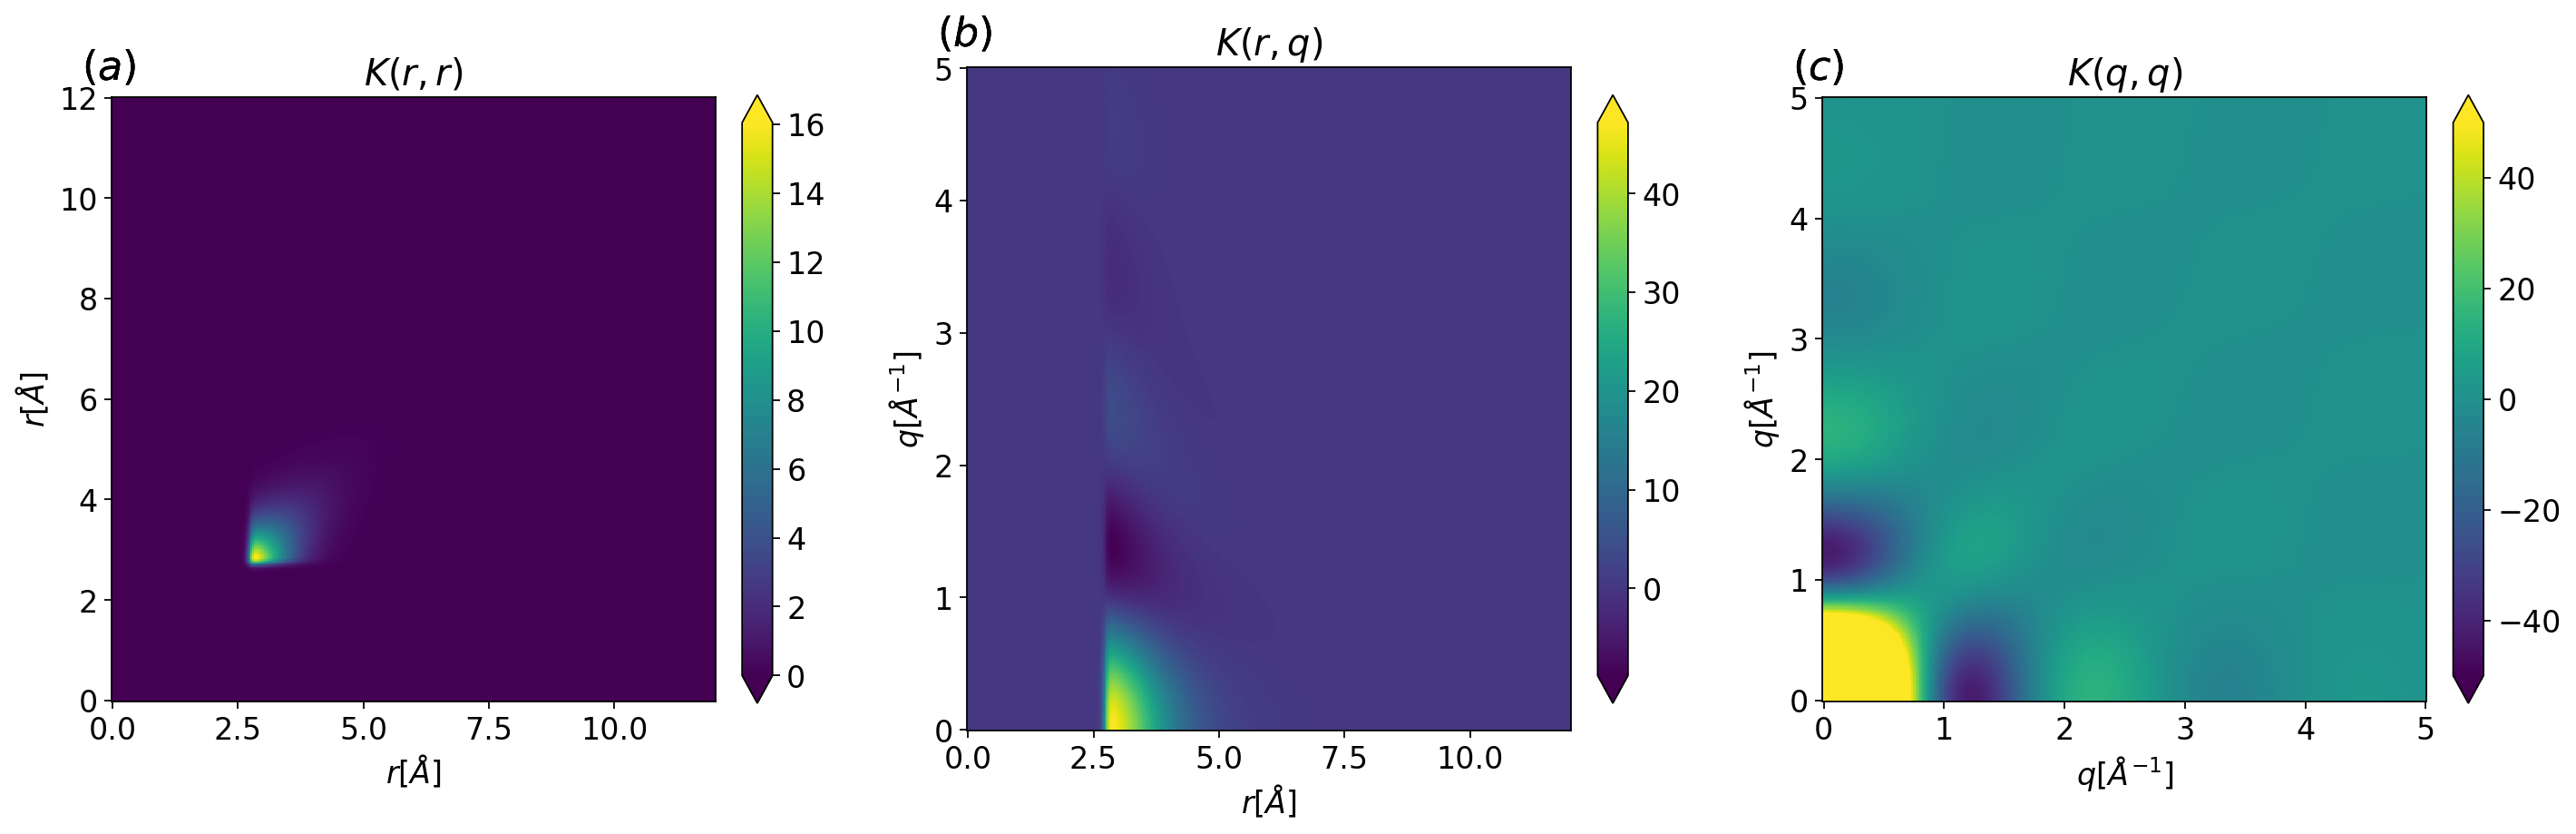

In [8]:
with torch.no_grad():
    r_infer_k_plot = torch.linspace(0.0001, 12, 400).reshape(-1,1)
    q_infer_k_plot = torch.linspace(0.0001, 5, 300).reshape(-1,1)
    
    bound = 50

    # Calculate kernel matrices for each domain
    K1_matrix = gp.K_rr(r_infer_k_plot,r_infer_k_plot,adjust=False).detach()
    K2_matrix = gp.K_rq(r_infer_k_plot,r_grid,q_infer_k_plot,adjust=False).T.detach()
    K3_matrix = gp.K_qq(r_grid,r_grid,q_infer_k_plot,q_infer_k_plot,adjust=False).detach()

    # Set up the figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=160)
    kernels = [(K1_matrix, r_infer_k_plot.T[0], r_infer_k_plot.T[0]), (K2_matrix, r_infer_k_plot.T[0], q_infer_k_plot.T[0]), (K3_matrix, q_infer_k_plot.T[0], q_infer_k_plot.T[0])]
    titles = ["$K(r,r)$", "$K(r,q)$", "$K(q,q)$"]
    xlabels = ["$r [\AA]$", "$r [\AA]$", "$q [\AA^{-1}]$"]
    ylabels = ["$r [\AA]$", "$q [\AA^{-1}]$", "$q [\AA^{-1}]$"]
    i = 0
    for idx, (ax, (kernel, x_dom, y_dom), title, xlabel, ylabel) in enumerate(
            zip(axs, kernels, titles, xlabels, ylabels)):

        if idx == 2:                                   # clamp & fixed range
            kernel = kernel.clamp(-bound, bound)
            c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(), kernel.numpy(),
                              shading='auto', cmap='viridis',
                              vmin=-bound, vmax=bound)
        else:
            c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(), kernel.numpy(),
                              shading='auto', cmap='viridis')

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if idx != 1:
            ax.set_aspect('equal')

        fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04,
                     extend='both', extendfrac=0.05)
        
        for i, ax in enumerate(axs.flat):
            label = f"$({string.ascii_lowercase[i]})$"
            ax.text(-0.05, 1.08, label,
                    transform=ax.transAxes,
                    fontsize=lettering_size, va='top', ha='left')

    plt.tight_layout()
    plt.savefig("figs/OO_Simulated_kernels.png")

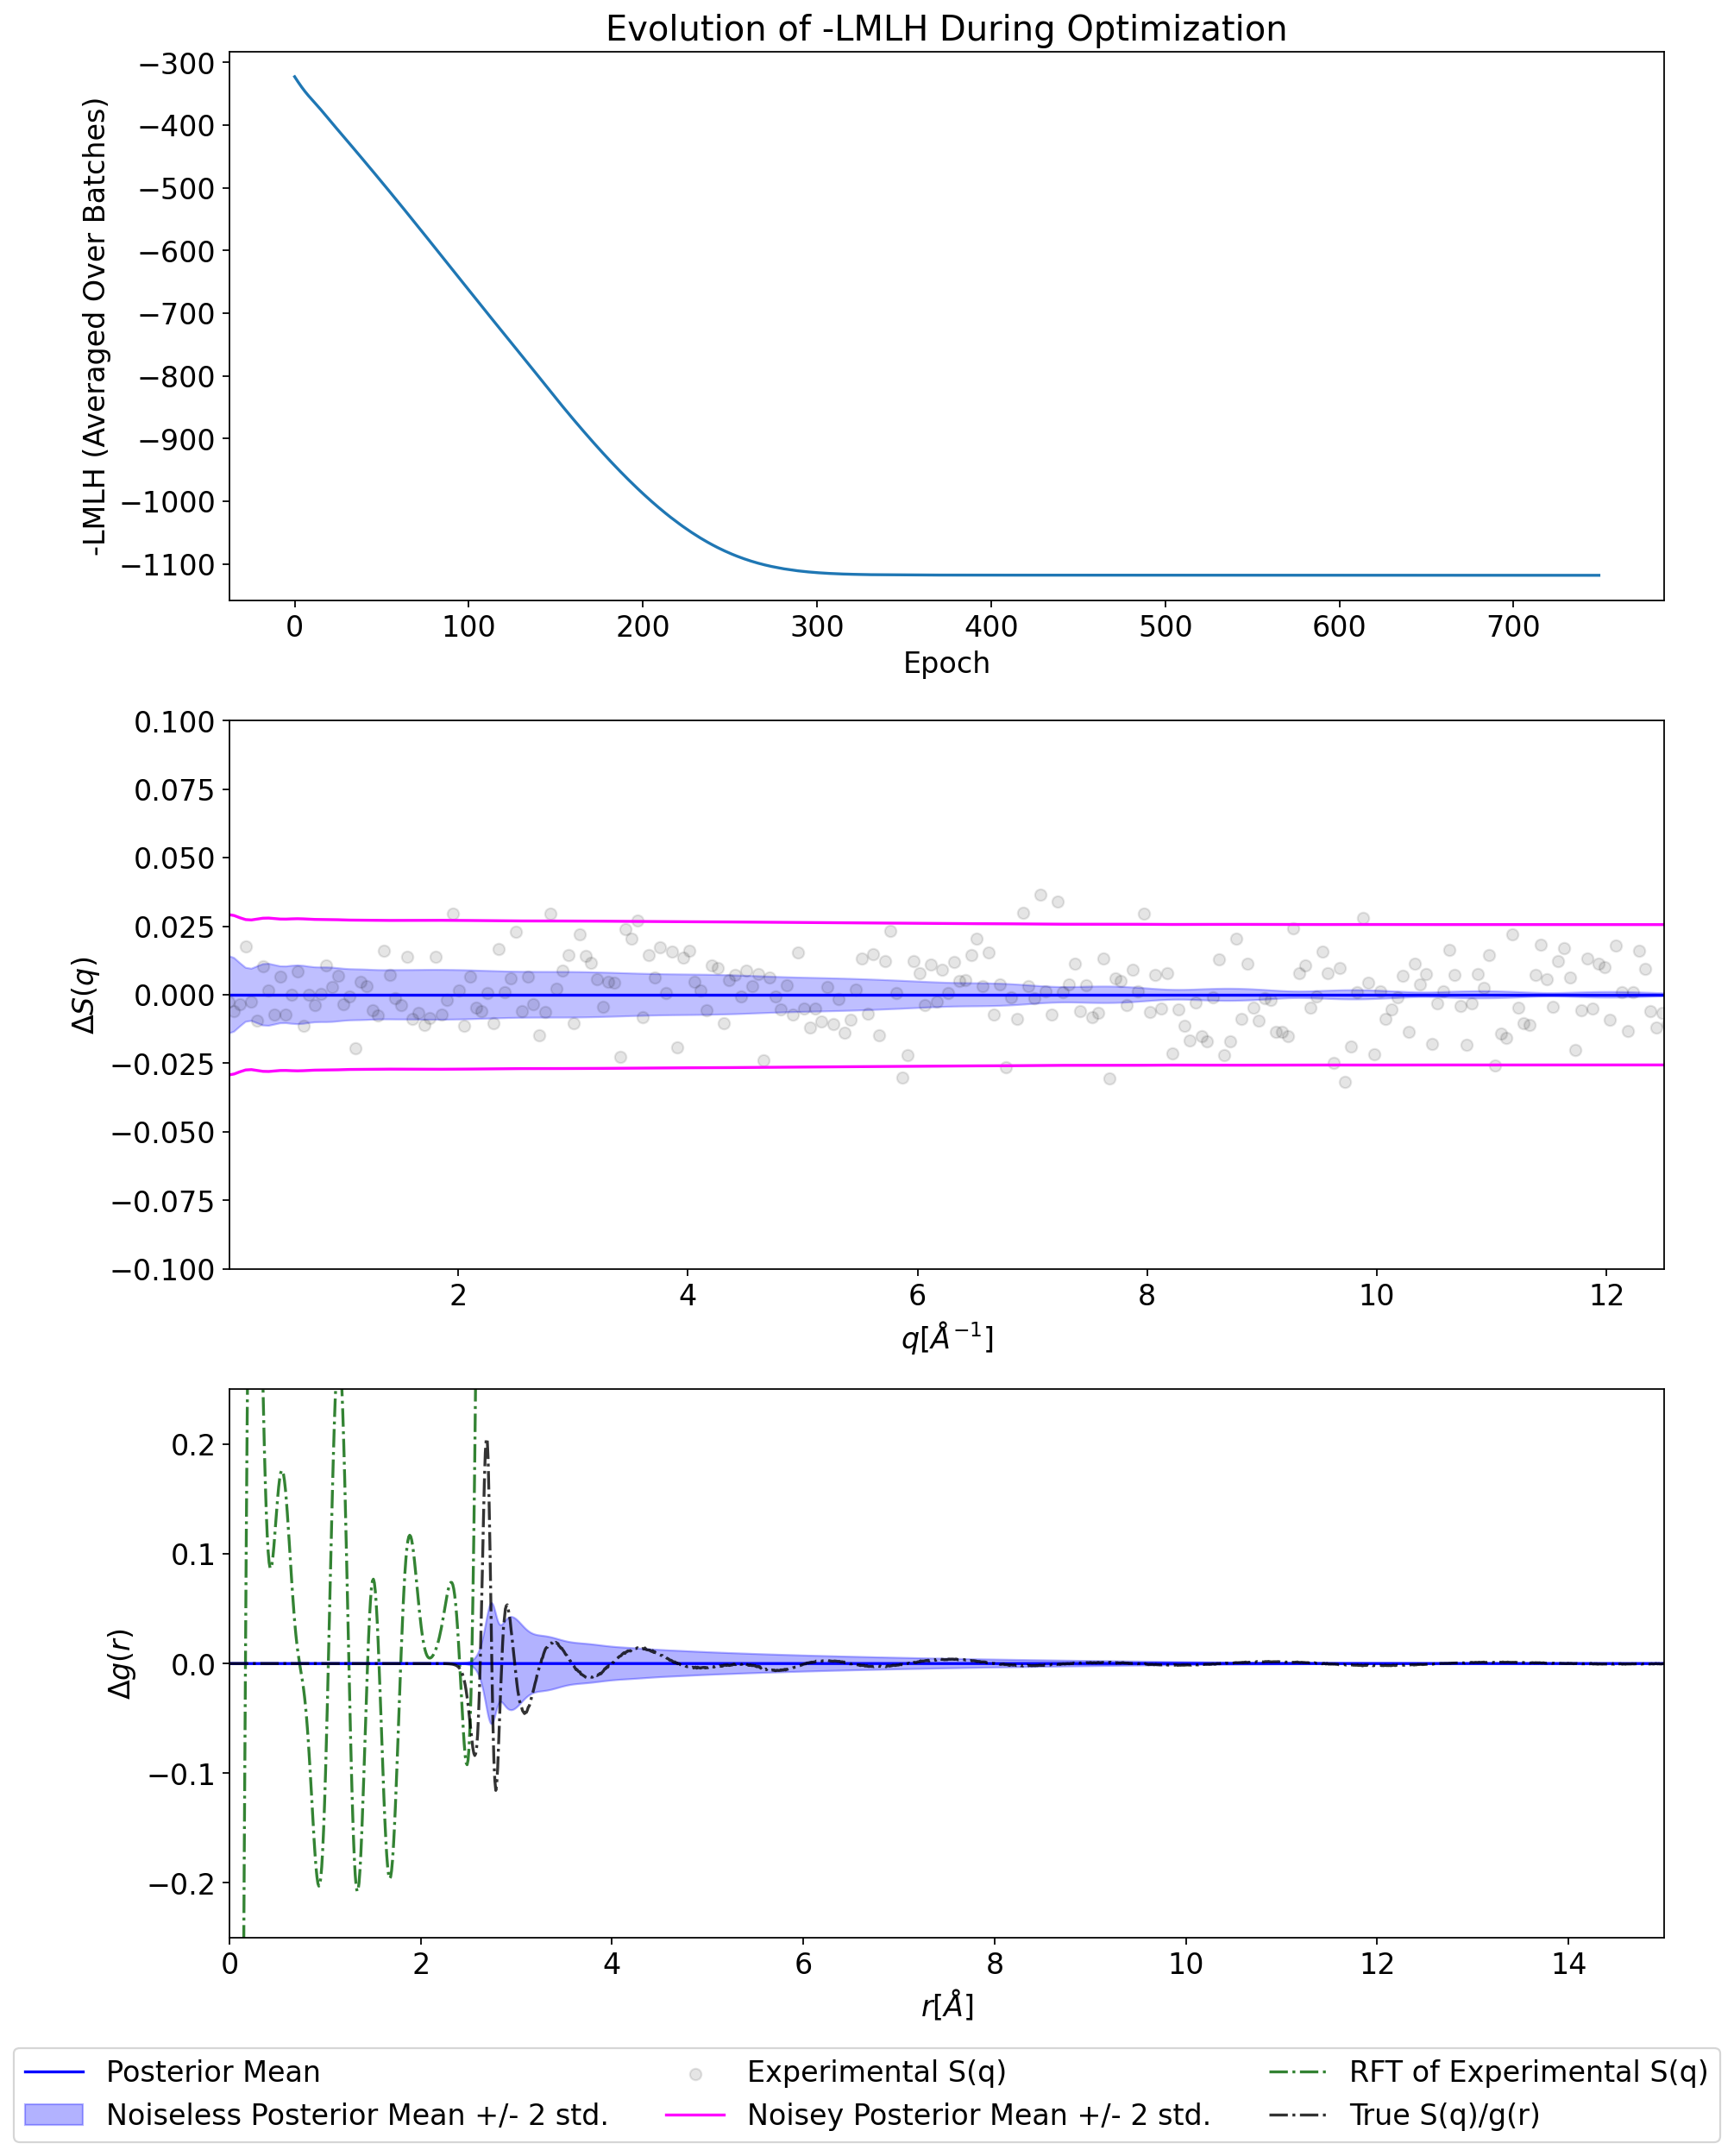

In [9]:
with torch.no_grad():
    fig, axs = plt.subplots(3,1, figsize=(12, 15), dpi=160)
    
    q_infer = q_train
        
    # Calculate Prior Mean and Cov
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    
    Σ_r_prior = gp.K_rr(r.reshape(-1,1),r.reshape(-1,1)).detach()
    μ_r_prior = gp.mean_r(r.reshape(-1,1)).detach()

    # Calculate Posterior Mean and Cov
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r.reshape(-1,1), q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()    
        
    axs[1].plot(q_infer.T[0],torch.zeros_like(q_infer.T[0]),label="Posterior Mean",color='b')
    axs[1].fill_between(q_infer.T[0],2*torch.diag(Σ_q_post)**0.5,  -2*torch.diag(Σ_q_post)**0.5,alpha=0.25,label="Noiseless Posterior Mean +/- 2 std.",color='b')
    axs[1].scatter(q_train,sq_train-μ_q_post,label='Experimental S(q)',alpha=0.1,color='k')
    axs[1].plot(q_infer.T[0],2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,label="Noisey Posterior Mean +/- 2 std.",color='magenta')
    axs[1].plot(q_infer.T[0],-2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,color='magenta')

    axs[1].set_xlim(0.01,12.5)
    axs[1].set_ylim(-0.1,0.1)

    axs[1].set_xlabel('$q [Å^{-1}]$')
    axs[1].set_ylabel('$\Delta S(q)$')
    
    # axs[2].plot(r, μ_r_prior.T[0] - μ_r_post.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    # axs[2].fill_between(r, μ_r_prior.T[0]- μ_r_post.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0]- μ_r_post.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
    axs[2].plot(r, gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r, density)+1 - μ_r_post[0], label='RFT of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
    axs[2].plot(r, μ_r_post.T[0]- μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[2].fill_between(r, μ_r_post.T[0]- μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0]- μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Noiseless Posterior Mean +/- 2 std.", color='b')
    axs[2].plot(r,gr_OO - μ_r_post.T[0] , label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
    
    axs[2].set_ylim(-0.25,0.25)
    axs[2].set_xlim(0,15)
    axs[2].set_xlabel('$r [Å]$')
    axs[2].set_ylabel('$\Delta g(r)$')


    axs[0].plot(torch.tensor(losses), linestyle='-')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('-LMLH (Averaged Over Batches)')
    axs[0].set_title('Evolution of -LMLH During Optimization')
    
    # Collect unique legend handles and labels
    handles1, labels1 = axs[1].get_legend_handles_labels()
    handles2, labels2 = axs[2].get_legend_handles_labels()

    # Use dict to ensure uniqueness
    handle_label_dict = dict(zip(labels1 + labels2, handles1 + handles2))
    labels_combined, handles_combined = zip(*handle_label_dict.items())

    # Add figure-level legend below all subplots
    fig.legend(
        handles_combined, labels_combined,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=True
    )

plt.tight_layout()
plt.savefig("figs/OO_simulated_si.png", bbox_inches='tight')